# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Part 3: EDA + Preliminary Analysis

## Importing libraries and data

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import requests
import bs4
from bs4 import BeautifulSoup
from selenium import webdriver

import re
import time
import json

In [79]:
# importing cleaned data
pets_df = pd.read_csv('/Users/lewis/Desktop/GA/DSI25-lessons/projects/project-capstone/data/pets4homes_data_cleaned',
                     index_col = 'Unnamed: 0')

In [80]:
# creating a data dictionary 
pets_df_dictionary = {
    'title' : 'The title of the listing',
    'price' : 'The price of the listed pet',
    'url' : 'The URL of the listing',
    'phone_verified' : "Whether the seller's profile has been verified by phone",
    'email_verified' : "Whether the seller's profile has been verified by email",
    'facebook_verified' : "Whether the seller's profile has been verified by Facebook",
    'google_verified' : "Whether the seller's profile has been verified by Google",
    'n_images' : 'The number of images included in the listing',
    'category' : 'The type of animal',
    'advert_id' : "The listing's unique ID",
    'advert_location' : "The location of the seller",
    'advertiser_type' : 'The type of seller',
    'breed' : 'The breed of the pet(s) being sold',
    'pet_age' : 'The age of the pet(s) being sold',
    'pet_colour' : 'The colour of the pet(s) being sold',
    'pet_sex' : 'The sex of the pet(s) being sold',
    'description' : 'The listing description provided by the seller',
    'health_checked' : 'Whether the pets(s) have been health checked',
    'microchipped' : 'Whether the pets(s) have been microchipped',
    'neutered' : "Whether the pet(s) have been neutered",
    'vaccinated' : "Whether the pet(s) have been vaccinated",
    'worm_treated' : "Whether the pet(s) have been worm treated",
    'registered' : "Whether the pet(s) are registered with a breeders or owners club/society",
    'original_breeder' : 'Whether the seller is the original breeder of the pet',
    'viewable_with_mother' : "Whether the pet is viewable with it's mother",
    'category_1' : 'The primary category of a horse', 
    'category_2' : 'The secondary category of a horse',
    'height' : 'The height of a horse (measured in hands)',
    'origin' : 'The origin of a horse',
    'jumping_horse' : 'Whether a horse does show jumping',
    'dressage_horse' : 'Wether a horse does dressage',
    'seller_n_adverts' : 'The number of adverts that seller had at the time of data collection',
    'pets_age_in_days' : "The age of the pet(s), measured in days",
    'males_in_litter' : "The number of male pets in the litter",
    'females_in_litter' : "The number of female pets in the litter"}

## Initial overview

In [81]:
# checking the types of the columns 
pets_df.dtypes

title                    object
price                   float64
url                      object
phone_verified          float64
email_verified          float64
facebook_verified       float64
google_verified         float64
n_images                  int64
category                 object
advert_id                object
advert_location          object
advertiser_type          object
breed                    object
pet_age                  object
pet_colour               object
pet_sex                  object
description              object
health_checked           object
microchipped             object
neutered                 object
vaccinated               object
worm_treated             object
registered               object
original_breeder         object
viewable_with_mother     object
category_1               object
category_2               object
height                   object
origin                   object
jumping_horse            object
dressage_horse           object
seller_n

The majority of the columns are currently encoded as object/string type. Some processing will be needed to get these ready for EDA. As such, I've split the variables according to their statistical data type (i.e. catergorical, continuous etc.). 

There are several variables which have 4 levels, but are actually binary (see the binary_vars_with_NAs list). These are variables which only apply to certain animal types and so had NaNs for those animal types to which they did not apply. During cleaning, I replaced those NaNs with 'Not applicable'. There were also NaNs where the column was applicable, but the seller had not listed that information. I replaced these with 'Unlisted'. These columns will need some additional processing to the other binary variables, hence the seperate list.

The two groupings which are not by statistical data type are the text columns (title, description) and the id variables (advert_id, url). The former requires npl based processing. The latter are included for reference only and so will not form part of the EDA or model predictors.

In [82]:
continuous_vars = ['price', 
                   'n_images', 
                   'seller_n_adverts', 
                   'pets_age_in_days',
                   'males_in_litter',
                   'females_in_litter']

# variables currently encoded as binary
binary_vars = ['phone_verified', 
               'email_verified', 
               'facebook_verified', 
               'google_verified']

# 'binary' variables with 'not applicable' as a level, which needs to be set aside 
# for EDA 
binary_vars_with_NAs = ['microchipped',
                        'neutered',
                        'vaccinated',
                        'worm_treated',
                        'registered',
                        'original_breeder',
                        'viewable_with_mother',
                        'jumping_horse',
                        'dressage_horse']


catergorical_vars_true = ['category',
                          'advert_location',
                          'advertiser_type',
                          'breed',
                          'pet_colour',
                          'pet_sex', # 3 levels due to 'mixed'
                          'category_1',
                          'category_2']

text_vars = ['title',
            'description']

id_vars = ['url',
           'advert_id']

Some variables I thought I had removed during cleaning are still present. I'm deleting them before moving on.

In [83]:
pets_df.drop(columns = ['height', 'jumping_horse', 'dressage_horse'], inplace = True)

## Continuous variables

In [84]:
pets_df[continuous_vars].dtypes

price                float64
n_images               int64
seller_n_adverts       int64
pets_age_in_days     float64
males_in_litter       object
females_in_litter     object
dtype: object

The fe/males_in_litter columns are continuous, but only apply to dogs and cats. Before analysing these, I'll need move the 'Not applicable' and 'Unlisted' values to other columns to include these in the continuous variable analysis.

In [85]:
# creating new columns
    # N/A
pets_df['males_in_litter_NA'] = 0
pets_df['females_in_litter_NA'] = 0
    # Unlisted
pets_df['males_in_litter_UNLISTED'] = 0
pets_df['females_in_litter_UNLISTED'] = 0


# transfering over values
    # N/A
pets_df.loc[pets_df['males_in_litter'] == 'Not applicable','males_in_litter_NA'] = 1
pets_df.loc[pets_df['females_in_litter'] == 'Not applicable','females_in_litter_NA'] = 1
    # Unlisted
pets_df.loc[pets_df['males_in_litter'] == 'Unlisted','males_in_litter_UNLISTED'] = 1
pets_df.loc[pets_df['females_in_litter'] == 'Unlisted','females_in_litter_UNLISTED'] = 1


# adding new cols to binary_vars
binary_vars.append('males_in_litter_NA')
binary_vars.append('females_in_litter_NA')
binary_vars.append('males_in_litter_UNLISTED')
binary_vars.append('females_in_litter_UNLISTED')

# changing original values to 0
    # N/A
pets_df.loc[pets_df['males_in_litter'] == 'Not applicable','males_in_litter'] = 0
pets_df.loc[pets_df['females_in_litter'] == 'Not applicable','females_in_litter'] = 0
    # Unlisted
pets_df.loc[pets_df['males_in_litter'] == 'Unlisted','males_in_litter'] = 0
pets_df.loc[pets_df['females_in_litter'] == 'Unlisted','females_in_litter'] = 0


# updating type of original columns
pets_df['males_in_litter'] = pets_df['males_in_litter'].astype(float)
pets_df['females_in_litter'] = pets_df['females_in_litter'].astype(float)

pets_df[continuous_vars].dtypes

price                float64
n_images               int64
seller_n_adverts       int64
pets_age_in_days     float64
males_in_litter      float64
females_in_litter    float64
dtype: object

In [86]:
pets_df[pets_df['pets_age_in_days'] == pets_df['pets_age_in_days'].max()]['title'].values

array(['Female Herman Tortoise with full set up '], dtype=object)

In [87]:
2023 - 732737/365

15.501369863013679

I've begun by using .describe() and a z-scaled box plot to get a general overview of the continuous variables (see below). These both show that all columns have some significant outliers. For n_images and seller_n_adverts, these outliers are plausible data points (140 is a much larger number of adverts than most, but many listings are by liscenced breeders and businesses). However, for price, pet_age_in_days and fe/males_in_litter, the max values are clearly incorrect (unless theres a 2000 year old tortoise in the dataset). The minimum value for price is 0, which must also be incorrect. 

I'll remove these outliers and run .describe() and the box plot again. As several of these variables may be strongly right skewed, I will begin conservatively by removing only the rows with the most extreme outliers (i.e. those >20 in the z-scaled data).

In [88]:
pd.options.display.float_format = '{:20,.2f}'.format
pets_df[continuous_vars].describe()

,price,n_images,seller_n_adverts,pets_age_in_days,males_in_litter,females_in_litter
count,"19,271.00","19,271.00","19,271.00","19,271.00","19,271.00","19,271.00"
mean,"2,497.12",8.69,4.09,329.76,1.14,1.10
std,"171,259.47",7.50,12.85,"5,308.21",4.95,4.93
min,0.00,1.00,1.00,0.00,0.00,0.00
25%,70.00,4.00,1.00,55.00,0.00,0.00
50%,550.00,6.00,2.00,94.00,0.00,0.00
75%,"1,000.00",11.00,3.00,255.50,2.00,2.00
max,"21,474,836.00",41.00,140.00,"732,737.62",650.00,650.00


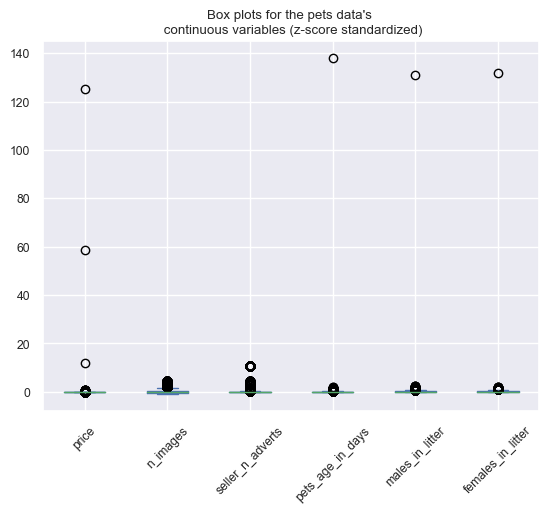

In [89]:
# z-score scaling the data
sats_zscaled = pd.DataFrame(stats.zscore(pets_df[continuous_vars]))

# adding column names to sats_zscaled
sats_zscaled.columns = continuous_vars

# plotting sats_zscaled
sats_zscaled.plot(kind='box', title = "Box plots for the pets data's \n continuous variables (z-score standardized)");
plt.xticks(rotation = 45);

In [90]:
# filtering out rows with zscaled > 20
# There is absolutely a better way to do this, but I'm too tired to figure it out right now
less_than_20 = sats_zscaled < 20
pets_df = pets_df[less_than_20['price'] & less_than_20['pets_age_in_days'] & less_than_20['males_in_litter'] & less_than_20['females_in_litter']]

# removing listings with a price of 0
pets_df = pets_df[pets_df['price'] > 0]

Below are the repeated .describe() and z-scaled box plot.
 - Both show that the price column still has some extreme outliers. The outlier cutoff will need to be reduced further.
 - The max value in the pets_age_in_days column is very large (roughly 31 years old), but not unplausible for some horses, fish, reptiles and birds. I will look at this row individually to check it's legitimacy.
 - The values for fe/males in litter are large, but not impossible. According to Pets4Homes "Litters of over eight pups are considered to be large, and over ten is rare, although up to seventeen live births have been recorded in some cases!" (https://www.pets4homes.co.uk/pet-advice/factors-that-determine-the-size-of-a-litter.html). Of course, the actual litter size must be the sum of the two columns. I will calculate this and remove any rows with a combined total greater than 12 (this is a somewhat arbitary cut off informed by the above information).

In [91]:
pets_df[continuous_vars].describe()

,price,n_images,seller_n_adverts,pets_age_in_days,males_in_litter,females_in_litter
count,"18,929.00","18,929.00","18,929.00","18,929.00","18,929.00","18,929.00"
mean,879.42,8.77,4.10,289.30,1.13,1.08
std,"14,757.69",7.52,12.88,575.49,1.63,1.58
min,0.20,1.00,1.00,0.00,0.00,0.00
25%,80.00,4.00,1.00,55.00,0.00,0.00
50%,550.00,6.00,2.00,93.00,0.00,0.00
75%,"1,000.00",11.00,3.00,252.50,2.00,2.00
max,"2,000,000.00",41.00,140.00,"11,315.00",13.00,10.00


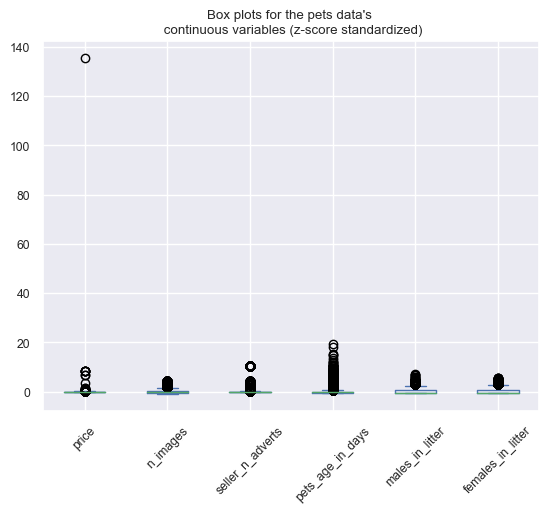

In [92]:
# z-score scaling the data
sats_zscaled = pd.DataFrame(stats.zscore(pets_df[continuous_vars]))

# adding column names to sats_zscaled
sats_zscaled.columns = continuous_vars

# plotting sats_zscaled
sats_zscaled.plot(kind='box', title = "Box plots for the pets data's \n continuous variables (z-score standardized)");
plt.xticks(rotation = 45);

In [93]:
# through visual inspection, I found a number of listings where the advertiser simply entered 12345 (etc.) as
# the price. I am assuming these are not legitimate prices and so will use this as a cutoff.
pets_df = pets_df[pets_df['price'] < 12345]

# I'm also going to drop ads where the price is 1234, as I suspect these are also illegitimate
pets_df = pets_df[pets_df['price'] != 1234]

In [94]:
# the previous cell removed the row with the greatest age, I'm now looking at the top 20 eldest animals to 
# gauge if futher cleaning is needed.
pets_df.sort_values('pets_age_in_days', ascending = False).head(20)

# all animals in the top 20 are either horses, fish or birds, some species of which can live up to or beyond
# 30 years (e.g. koi karp, parrots). These can be left as they are, with the exception of the listing with the
# greatest age, which is for infant axolotls (amphibians, but classes as fish by Pets4Homes). I'll drop this.
pets_df = pets_df[pets_df['advert_id'] != 'mNSQZ7OOl']

There may be other rows like the one I just removed, but due to the large range between the lifespans of the various animal types, they are difficult to detect. I considered searching the descriptions for keywords indicating that an animal is younger than it's listed name (e.g. 'baby', 'puppy'), but these could potentially pick up ads where people are using these terms as pet names (both literally and figuratively). Instead, I will rely on domain knowlegde to set some age caps for the categories who's breeds have more similar age ranges.

In [95]:
# The longest living rodent people keep as pets is the chinchilla, with a max life expectancy of 20 years
pets_df.drop(pets_df[(pets_df['category'] == "Rodents") & (pets_df['pets_age_in_days'] > 365*20)].index, inplace = True)

# It is very uncommon for cats to live longer than 20 years
pets_df.drop(pets_df[(pets_df['category'] == "Cats") & (pets_df['pets_age_in_days'] > 365*20)].index, inplace = True)

# it is very uncommon for dogs to live longer than 18 years
pets_df.drop(pets_df[(pets_df['category'] == "Dogs") & (pets_df['pets_age_in_days'] > 365*18)].index, inplace = True)

# it is very uncommon for rabbits to live longer than 14 years
pets_df.drop(pets_df[(pets_df['category'] == "Rabbits") & (pets_df['pets_age_in_days'] > 365*14)].index, inplace = True)


In [96]:
# removing any rows with a total litter size > 12
litter_size = pets_df['males_in_litter'] + pets_df['females_in_litter']
litter_size = litter_size <= 12
pets_df = pets_df[litter_size]

Below are the 3rd and final set of .describe() and z-scaled box plots for the continuous variables, with outliers removed. All of these variables have many values beyond the IQR * 1.5 range, but as they all have a strong right skew and the values are fairly continually distributed through these upper ranges, I am happy to leave these values in.

 -  **Price** - This will be my target variable. There is a very large range for price, from 20p up to £11,500. This is likely due to the very different animal categories in the dataset. As such, it will be worth taking a further look at the distribution of prices amongs the individual animal categories. As both the box plot and mean (£710.45) and mode (£550) show, price has a strong right skew.
 - **n_images** - All listings have at least 1 image. The listing with the most has 41. There is a slight right skew (mean 8.76, mode 6).
 - **seller_n_adverts** - A significant proportion of the adverts are listed by a seller with only one advert, although the majority are listed by sellers with two or more (mode 2). Although the max value is orders of magnitude larger than even the 75th percentile, I have decided to keep this range for reasons discussed above.
 - **pet_age_in_days** - Similarly to price, this variable has a very strong right skew. Values range from newborn (i.e. 0 days) to 25 years (9125 days). An individual breakdown by animal category is needed.
 - **fe/males_in__litter** - These columns show a strong right skew, but this is due to the large number of 0s for animals where this value is either not applicable or unlisted. I'll look at these distribution with histograms.

In [97]:
9125/365

25.0

In [98]:
pets_df[continuous_vars].describe()

,price,n_images,seller_n_adverts,pets_age_in_days,males_in_litter,females_in_litter
count,"18,848.00","18,848.00","18,848.00","18,848.00","18,848.00","18,848.00"
mean,710.45,8.76,4.10,288.39,1.12,1.07
std,755.22,7.51,12.90,564.46,1.61,1.55
min,0.20,1.00,1.00,0.00,0.00,0.00
25%,80.00,4.00,1.00,55.00,0.00,0.00
50%,550.00,6.00,2.00,93.00,0.00,0.00
75%,"1,000.00",11.00,3.00,253.50,2.00,2.00
max,"11,500.00",41.00,140.00,"9,125.00",12.00,10.00


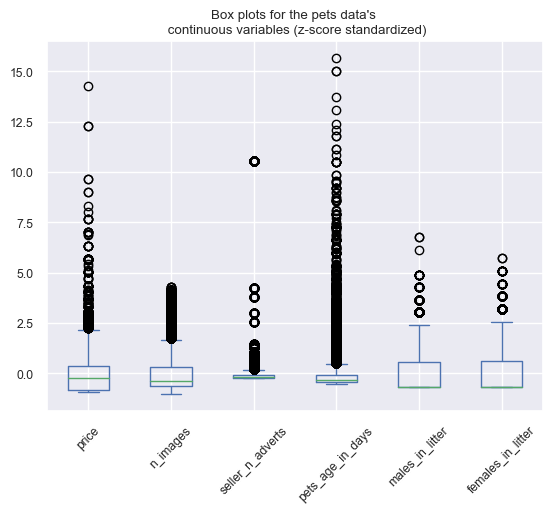

In [99]:
# z-score scaling the data
sats_zscaled = pd.DataFrame(stats.zscore(pets_df[continuous_vars]))

# adding column names to sats_zscaled
sats_zscaled.columns = continuous_vars

# plotting sats_zscaled
sats_zscaled.plot(kind='box', title = "Box plots for the pets data's \n continuous variables (z-score standardized)");
plt.xticks(rotation = 45);

In order to take a deeper look at the continuous variables as discussed in the previous textbox, I've created a number of histograms below. Each set of histograms has a summary in the textbox above it.

**Histograms showing the distribution of price by animal category**
All of the histograms for pet prices subsetted by pet category still show a strong right skew. However, the ranges between animal types varies greatly. For instance, the price range for invertibrates maxes out at around £250, where as the price range for horses maxes out at around £7000. Clearly, category will be an important predictor for price.

The categories with the least extreme right skew are dogs, cats and horses. These are also the categories with the largest maximum prices. This suggests that the outlier removal I have done so far has had little impact on the animal types with narrower price ranges. Given the extent of the skew for these categories, I have decided to perform futher outlier removal on them. Specifically, based on the z-scaled box plot below the histograms, I will remove values more than 8 standard deviations from the mean of each category. This will remove some of the most extreme and suspicious outliers whilst keeping the main distributions in tact.

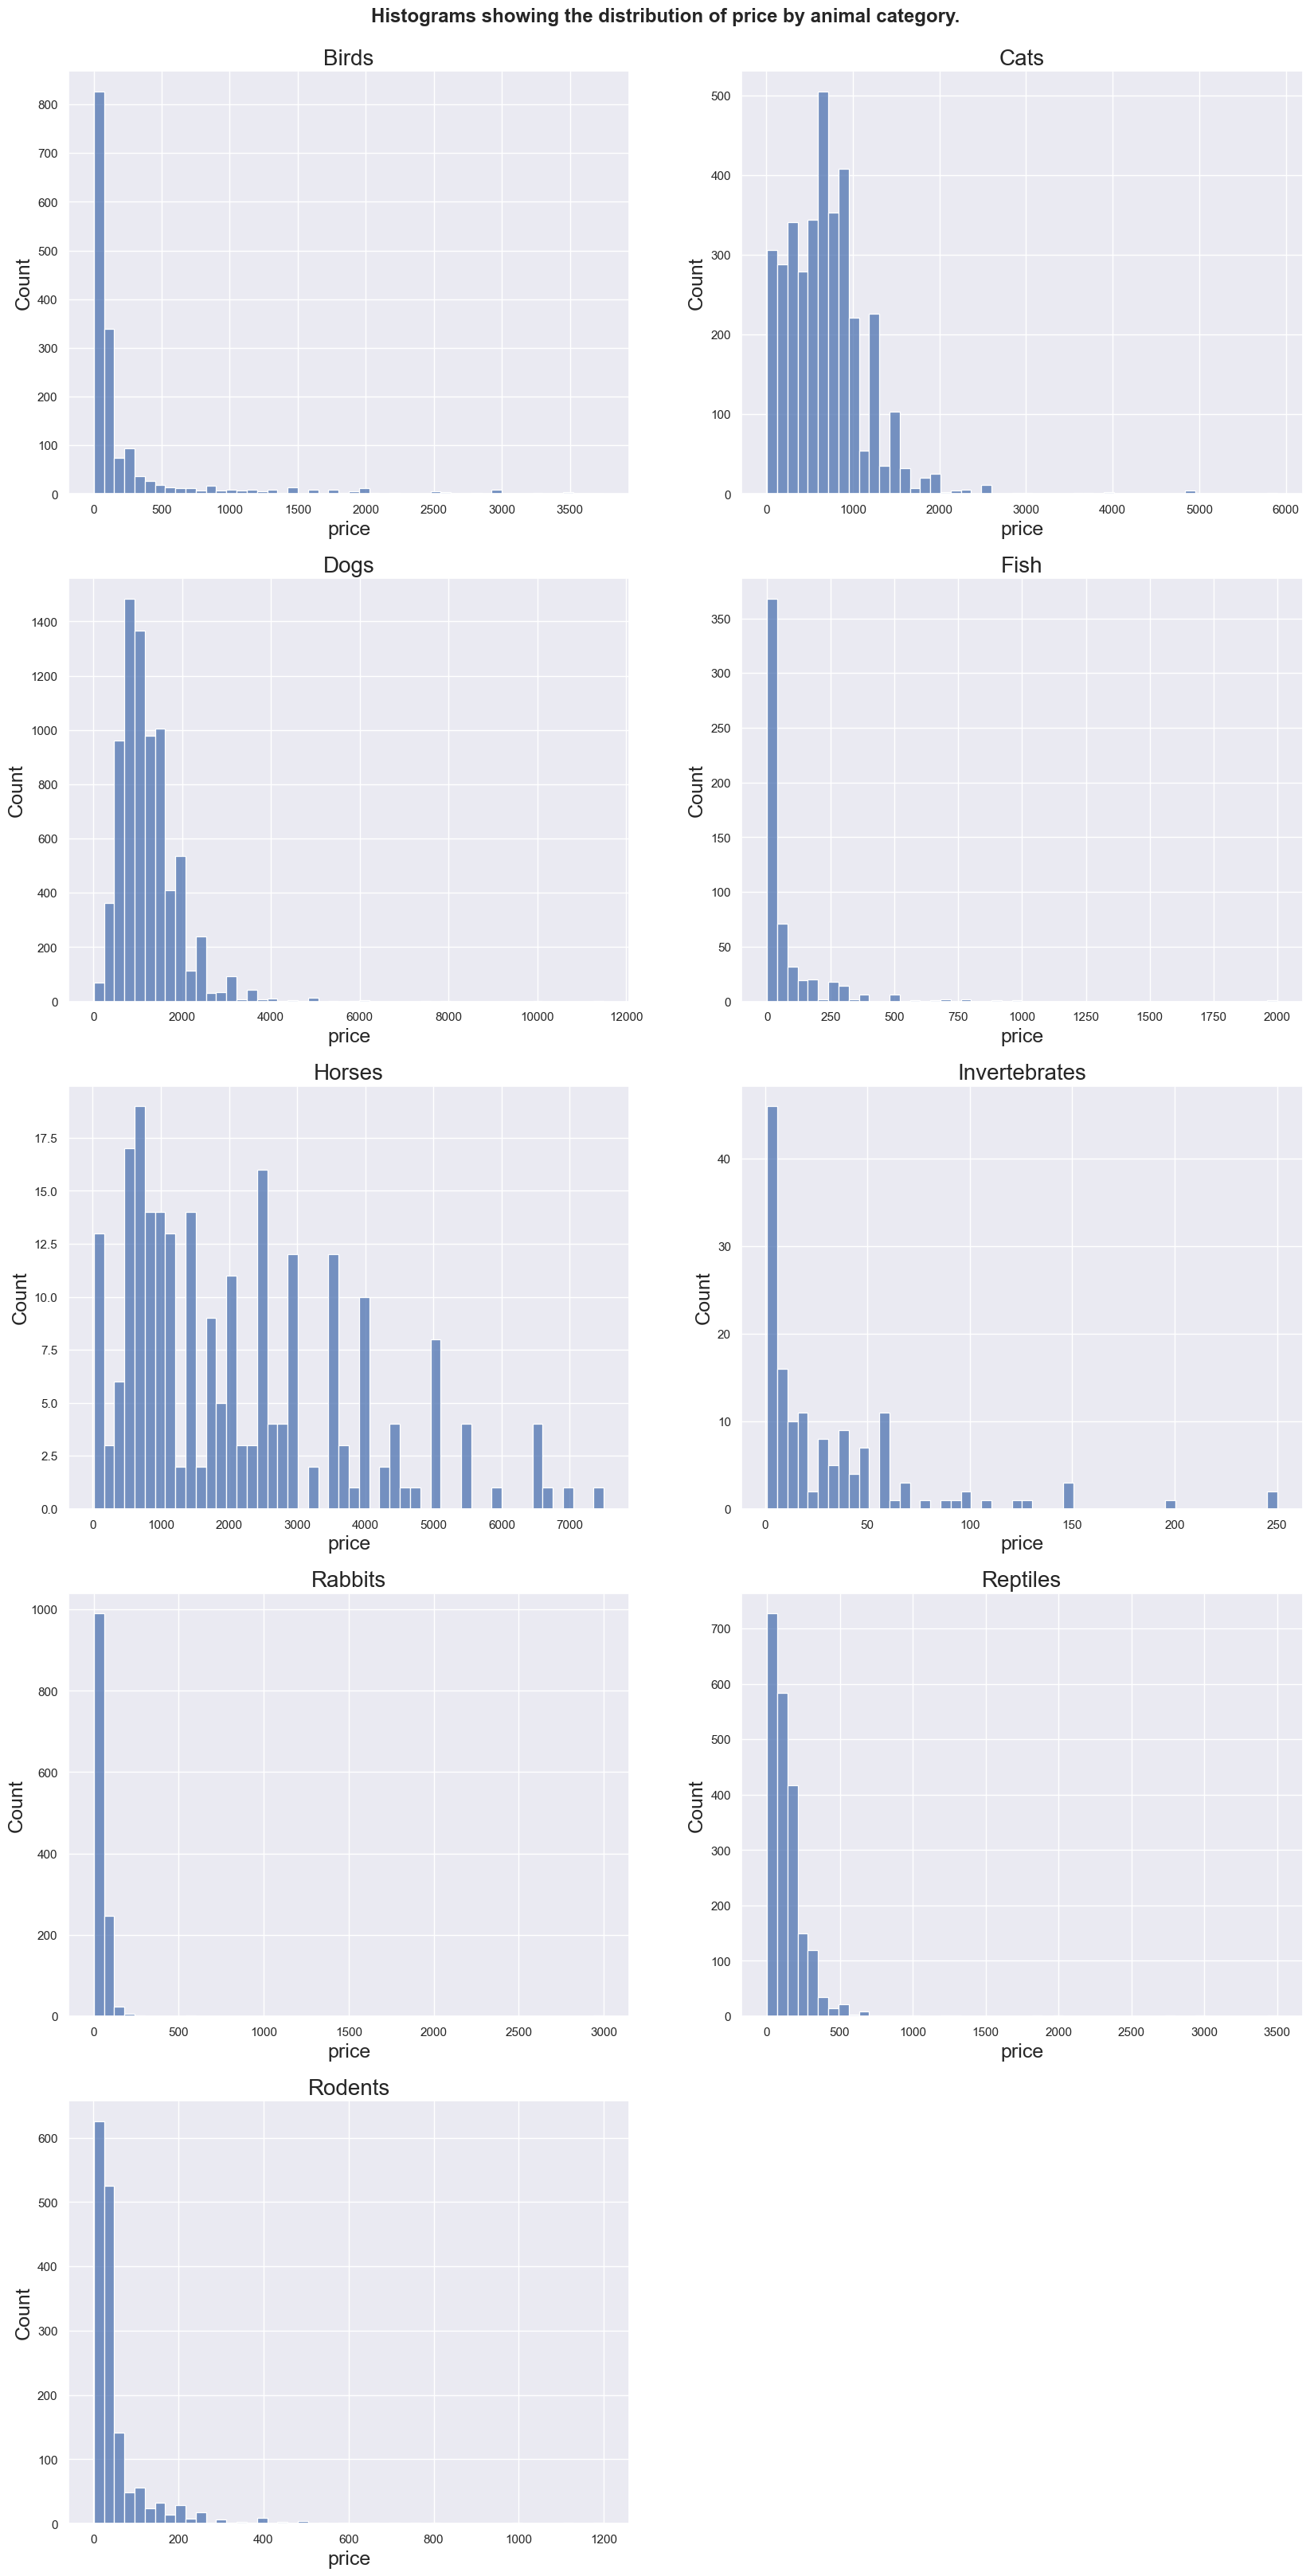

In [100]:
# setting label sizes
sns.set(rc = {'axes.labelsize' : 18 })

fig, ax = plt.subplots(5,2,figsize=(20,40))
fig.delaxes(ax[4,1])

# setting fig title
fig.suptitle("Histograms showing the distribution of price by animal category." ,
             fontsize = 'x-large', 
             fontweight = 'bold',
             y=.9);

# generating histograms
plot_row = 0
plot_col = 0

for i in range(0, len(pets_df['category'].unique()), 2):
    
    sns.histplot(pets_df[pets_df['category'] == pets_df['category'].unique()[i]]['price'],
                 bins = 50,
                 ax=ax[plot_row, plot_col]).set_title(pets_df['category'].unique()[i], size = 20)
    plot_col +=1
    
    if i+1 < 9:
        sns.histplot(pets_df[pets_df['category'] == pets_df['category'].unique()[i+1]]['price'],
                     bins = 50,
                     ax=ax[plot_row, plot_col]).set_title(pets_df['category'].unique()[i+1], size = 20)
    plot_col = 0
    plot_row += 1

/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/

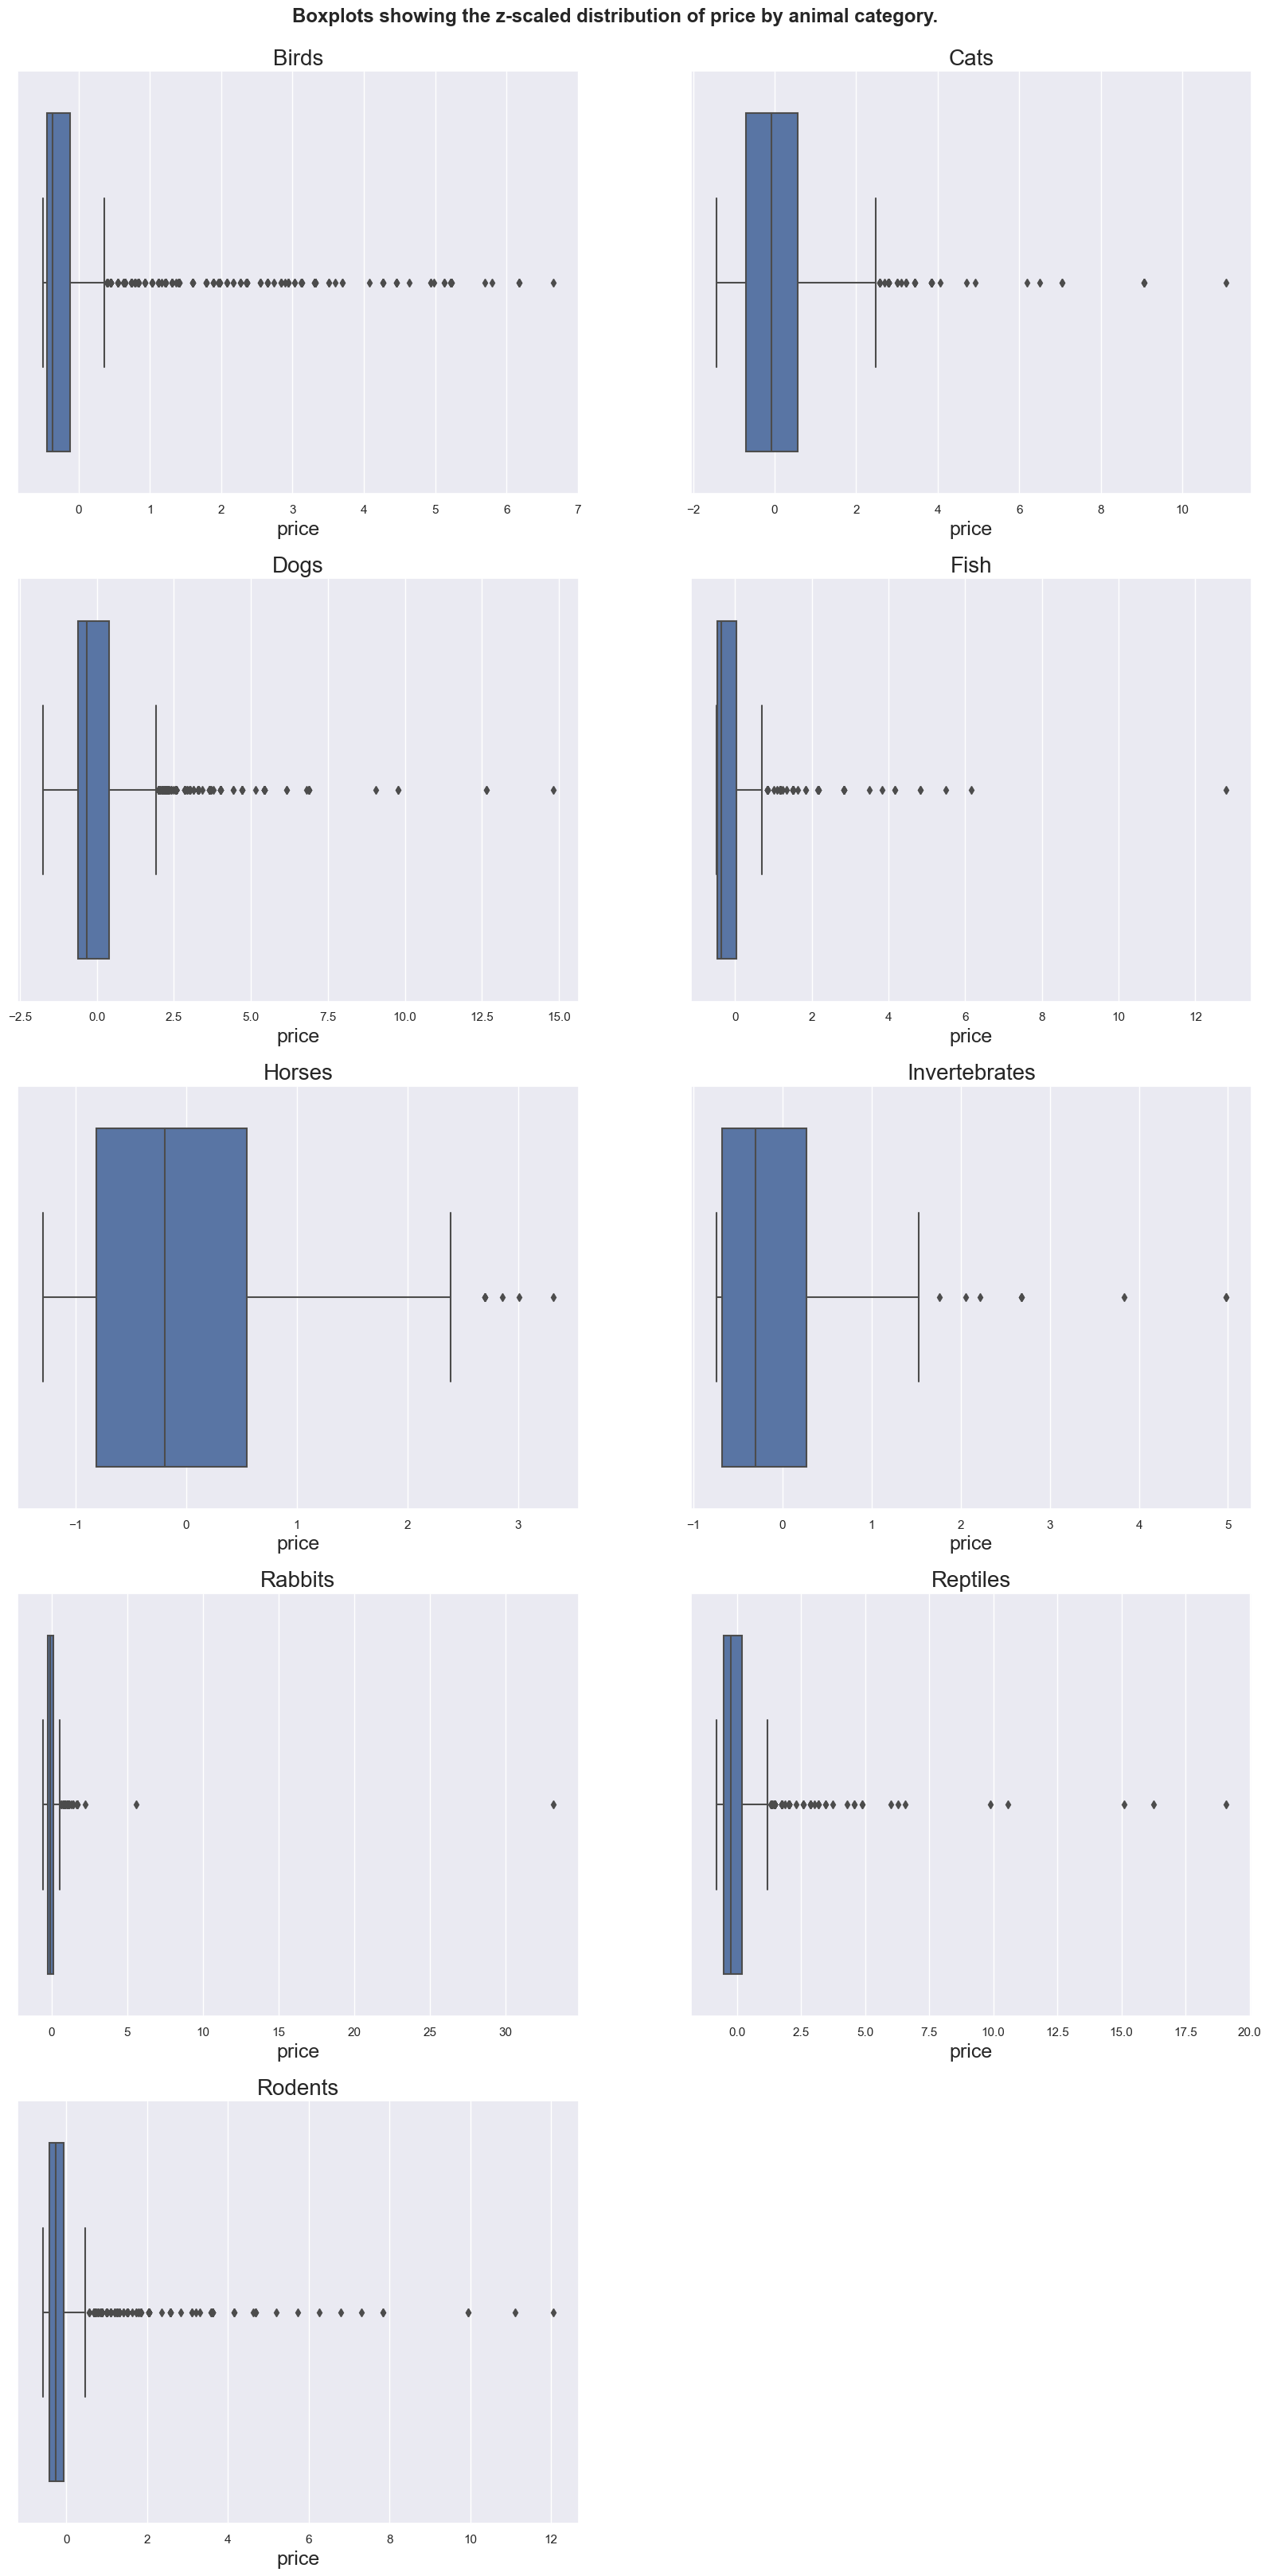

In [101]:
# setting label sizes
sns.set(rc = {'axes.labelsize' : 18 })

fig, ax = plt.subplots(5,2,figsize=(20,40))
fig.delaxes(ax[4,1])

# setting fig title
fig.suptitle("Boxplots showing the z-scaled distribution of price by animal category." ,
             fontsize = 'x-large', 
             fontweight = 'bold',
             y=.9);

# generating histograms
plot_row = 0
plot_col = 0

for i in range(0, len(pets_df['category'].unique()), 2):
    
    sns.boxplot(stats.zscore(pets_df[pets_df['category'] == pets_df['category'].unique()[i]]['price']),
               ax=ax[plot_row, plot_col]).set_title(pets_df['category'].unique()[i], size = 20)
    plot_col +=1
    
    if i+1 < 9:
        sns.boxplot(stats.zscore(pets_df[pets_df['category'] == pets_df['category'].unique()[i+1]]['price']),
                   ax=ax[plot_row, plot_col]).set_title(pets_df['category'].unique()[i+1], size = 20)
    plot_col = 0
    plot_row += 1

In the cell below, I've removed any rows where the price is greater than 8 stds from the mean of the price for that particular category. 

In [102]:
temp = pets_df.groupby('category')['price'].agg(['mean', 'std'])

temp['eight_stds_above_mean'] = temp['mean'] + (temp['std']*8)

n_rows = pets_df.shape[0]

for i in temp.index:
    pets_df = pets_df.loc[(pets_df['category'] != i) | ((pets_df['category'] == i) & (pets_df['price'] < temp.loc[i,'eight_stds_above_mean']))]

n_rows = n_rows - pets_df.shape[0]

print(f'{n_rows} price outliers dropped.')

22 price outliers dropped.


**Histograms showing the distribution of pet age by animal category.** As with the previous set of histograms, the histogrmas showing pet age by animal category all exhibit considerable right skew over ranges that are particular to each category. This is unsurprising as pets are most commonly sold as infants. This skew is least pronounced for horses. However, the zscaled box plots below indicate that this skew is less extreme than for price and most categories have a more regularly/densely populated tail, rather than a few extreme outliers. The excpetions to this are invertibrates, rodents and possibly fish. Both invertibrates and rodents have a single value which is extremely far from the main distribution. I will remove these two values, but otherwise leave pet age as is.

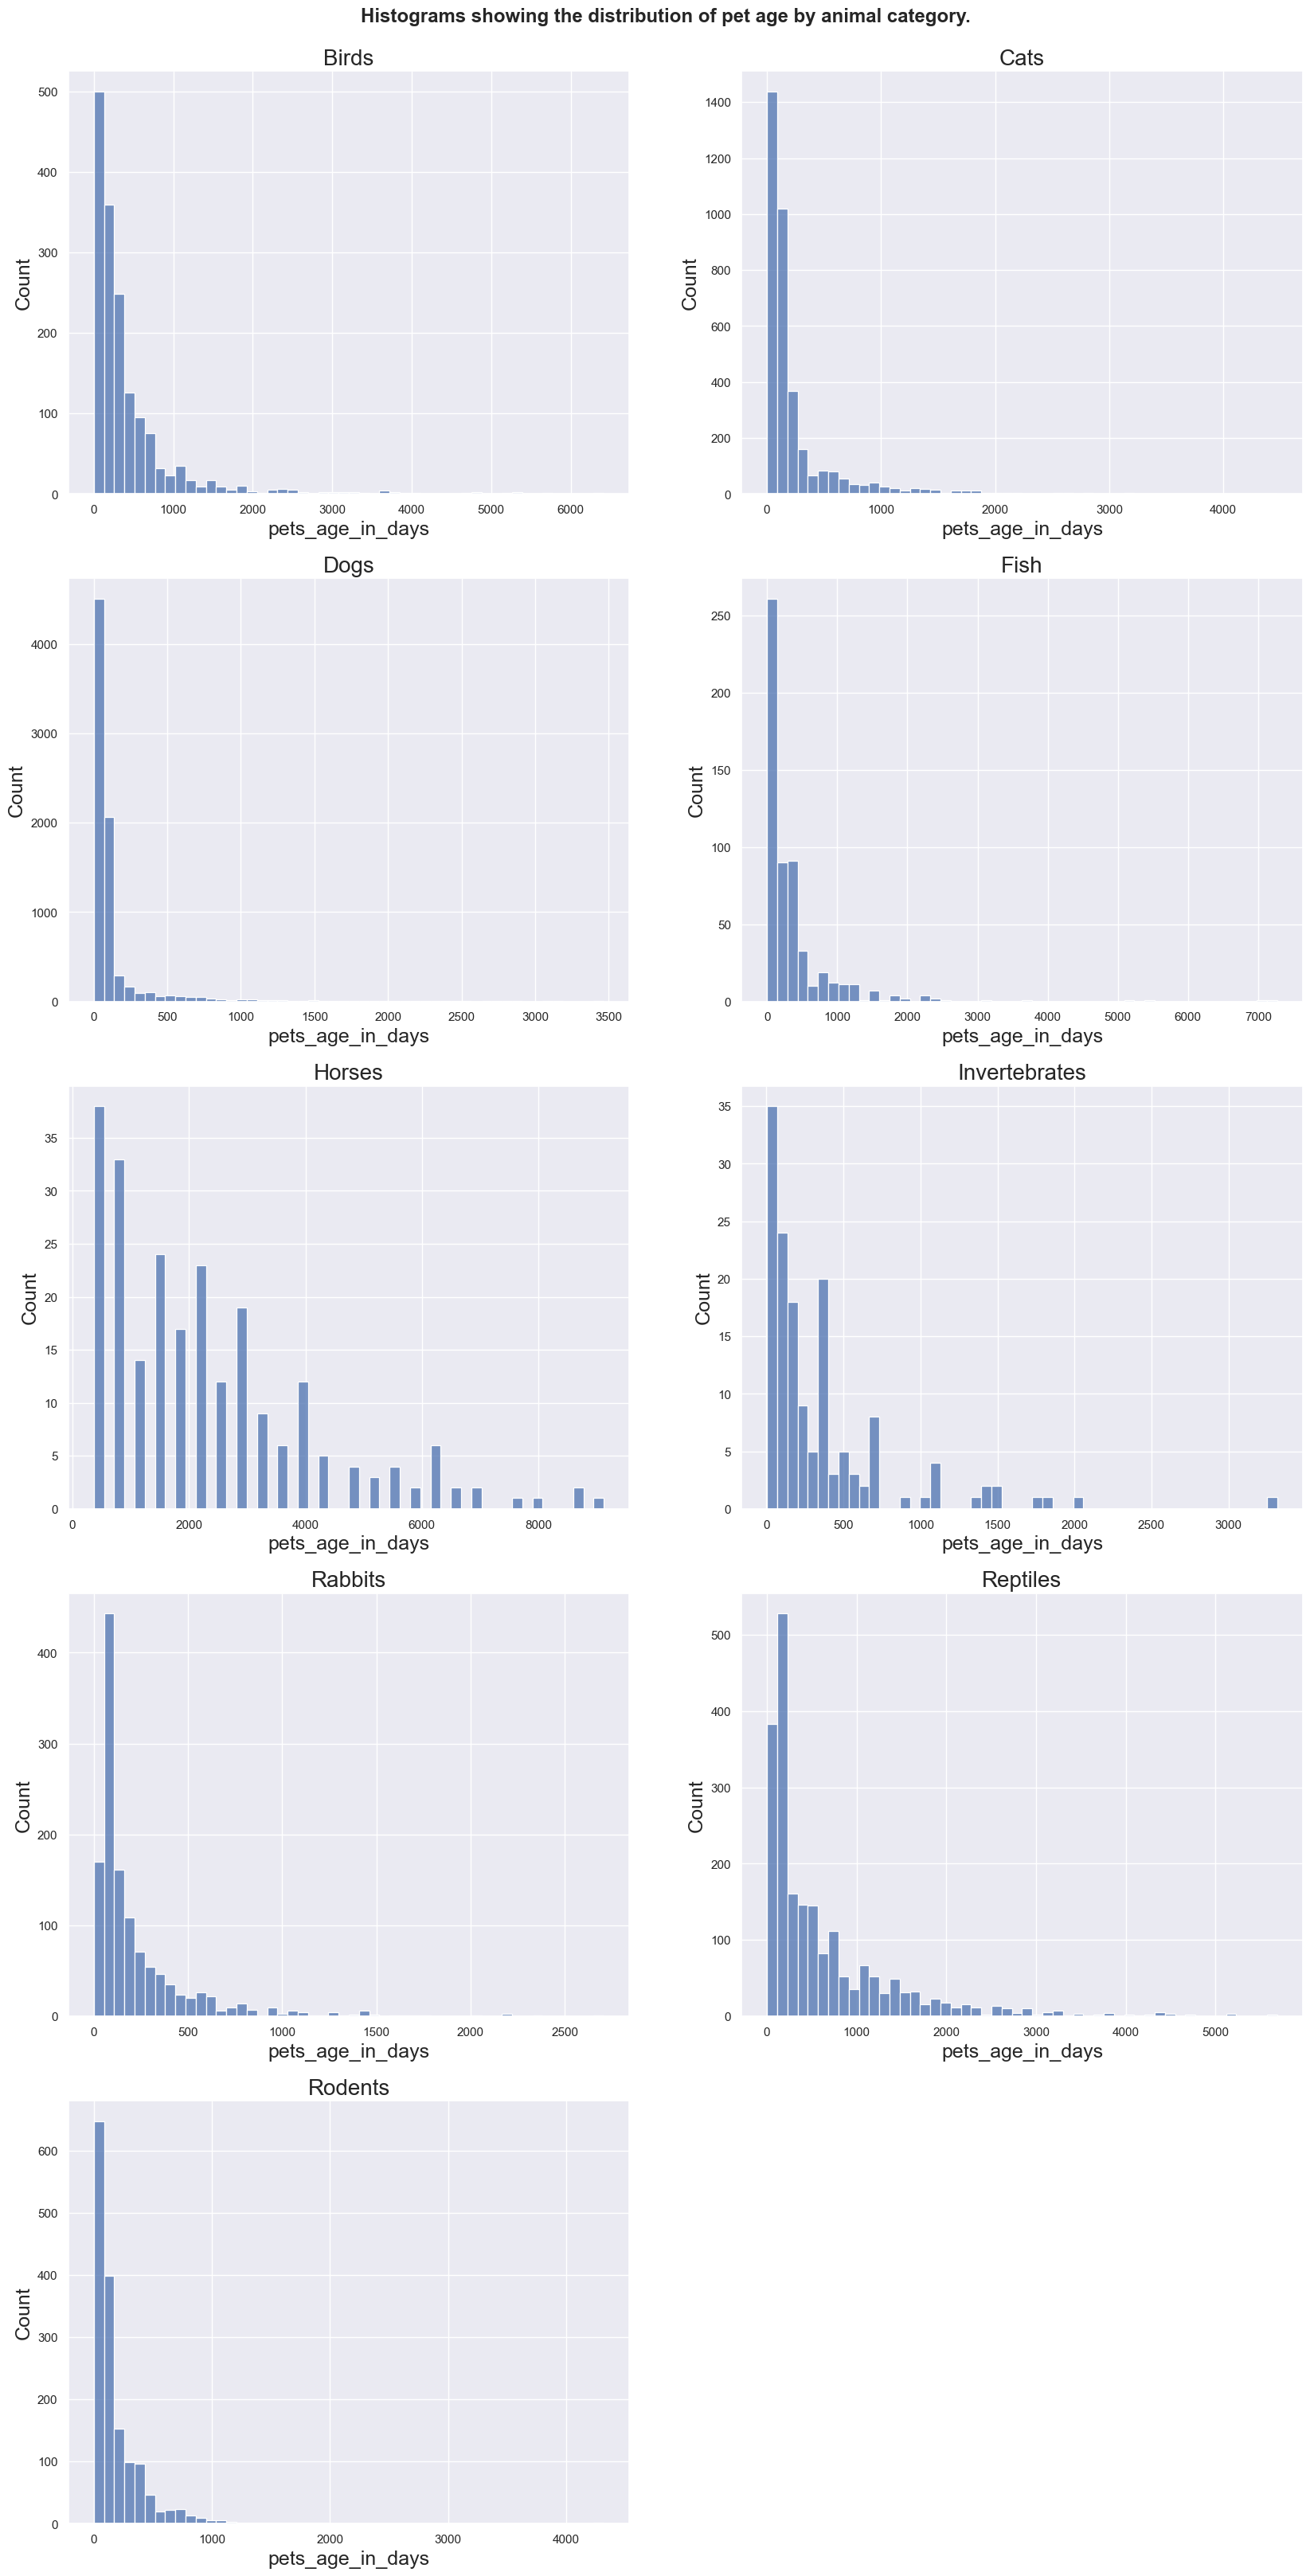

In [103]:
# setting label sizes
sns.set(rc = {'axes.labelsize' : 18 })

fig, ax = plt.subplots(5,2,figsize=(20,40))
fig.delaxes(ax[4,1])

# setting fig title
fig.suptitle("Histograms showing the distribution of pet age by animal category." ,
             fontsize = 'x-large', 
             fontweight = 'bold',
             y=.9);

# generating histograms
plot_row = 0
plot_col = 0

for i in range(0, len(pets_df['category'].unique()), 2):
    
    sns.histplot(pets_df[pets_df['category'] == pets_df['category'].unique()[i]]['pets_age_in_days'],
                 bins = 50,
                 ax=ax[plot_row, plot_col]).set_title(pets_df['category'].unique()[i], size = 20)
    plot_col +=1
    
    if i+1 < 9:
        sns.histplot(pets_df[pets_df['category'] == pets_df['category'].unique()[i+1]]['pets_age_in_days'],
                     bins = 50,
                     ax=ax[plot_row, plot_col]).set_title(pets_df['category'].unique()[i+1], size = 20)
    plot_col = 0
    plot_row += 1

/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/

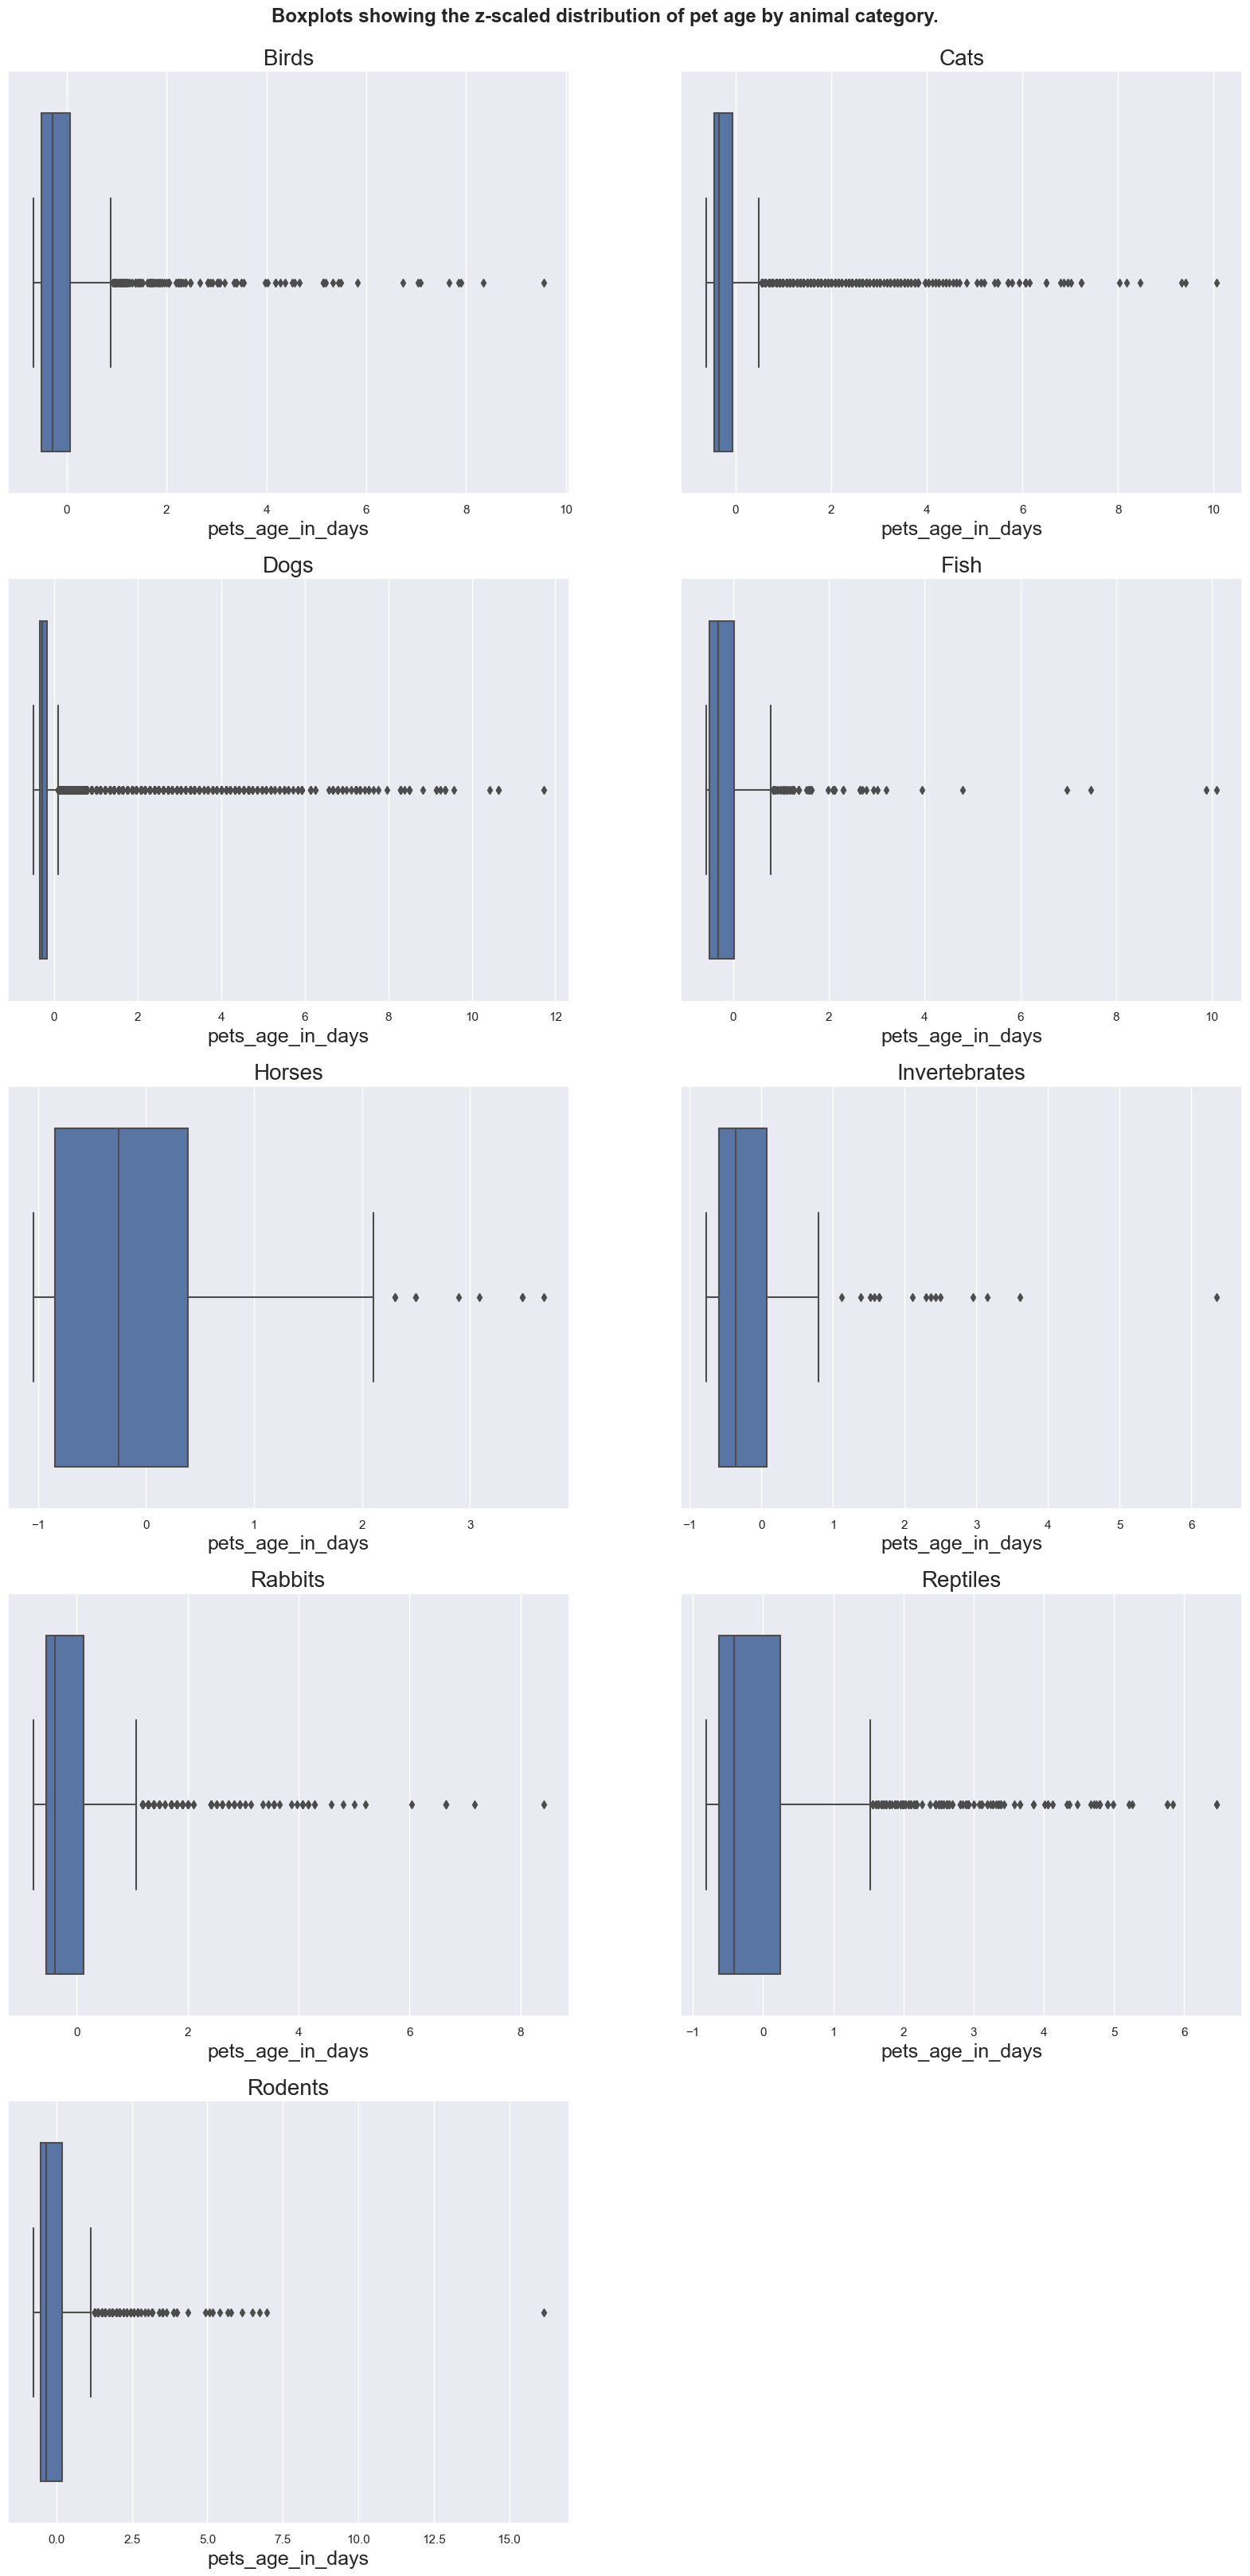

In [104]:
# setting label sizes
sns.set(rc = {'axes.labelsize' : 18 })

fig, ax = plt.subplots(5,2,figsize=(20,40))
fig.delaxes(ax[4,1])

# setting fig title
fig.suptitle("Boxplots showing the z-scaled distribution of pet age by animal category." ,
             fontsize = 'x-large', 
             fontweight = 'bold',
             y=.9);

# generating histograms
plot_row = 0
plot_col = 0

for i in range(0, len(pets_df['category'].unique()), 2):
    
    sns.boxplot(stats.zscore(pets_df[pets_df['category'] == pets_df['category'].unique()[i]]['pets_age_in_days']),
               ax=ax[plot_row, plot_col]).set_title(pets_df['category'].unique()[i], size = 20)
    plot_col +=1
    
    if i+1 < 9:
        sns.boxplot(stats.zscore(pets_df[pets_df['category'] == pets_df['category'].unique()[i+1]]['pets_age_in_days']),
                   ax=ax[plot_row, plot_col]).set_title(pets_df['category'].unique()[i+1], size = 20)
    plot_col = 0
    plot_row += 1

In [105]:
# dropping the invertebrates age outlier
invertebrates_outlier_age = pets_df.loc[pets_df['category']=='Invertebrates']['pets_age_in_days'].max()
pets_df = pets_df.loc[(pets_df['category'] != 'Invertebrates') | ((pets_df['category'] == 'Invertebrates') & (pets_df['pets_age_in_days'] < invertebrates_outlier_age))]

In [106]:
# dropping the rodents age outlier
rodents_outlier_age = pets_df.loc[pets_df['category']=='Rodents']['pets_age_in_days'].max()
pets_df = pets_df.loc[(pets_df['category'] != 'Rodents') | ((pets_df['category'] == 'Rodents') & (pets_df['pets_age_in_days'] < rodents_outlier_age))]

Text(0.5, 1.0, 'std of price by pet category')

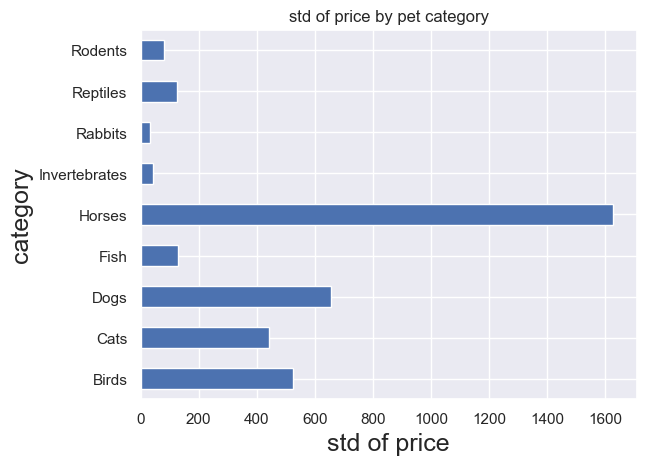

In [110]:
pets_df.groupby('category')['price'].std().plot(kind = 'barh')
plt.xlabel('std of price')
plt.title('std of price by pet category')

<AxesSubplot:ylabel='category'>

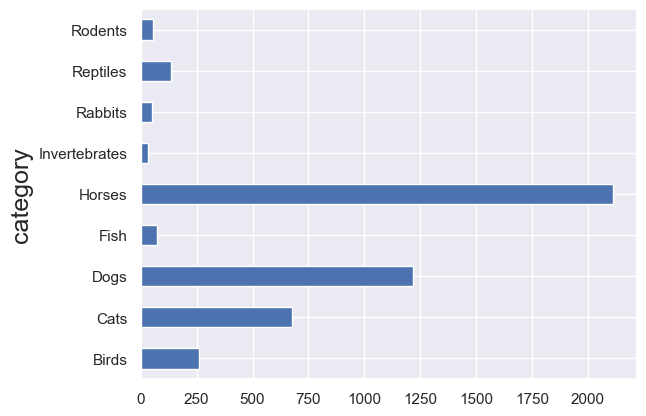

In [109]:
pets_df.groupby('category')['price'].mean().plot(kind = 'barh')

In [ ]:
price_by_cat = pd.concat([pets_df.groupby('category')['price'].std(), pets_df.groupby('category')['price'].mean()], axis=1);
cat_1_and_2.drop('Not applicable', inplace = True);
cat_1_and_2.plot(kind='barh');
plt.title('No. listings with category_1/category_2\n (Horses only)');
plt.xlabel('No. listings');
plt.ylabel('category');

**Histograms showing the distribution of males & females in litter by animal category.** The histograms below show the number of female and male puppies or kittens in a litter. These look as should be expected - they slowly slope off as the number of animals increases. Notably, for all but female kittens, the most common value is 0. These will be dog or cat listings where these variables were unlisted. For some of these, the seller will have failed to list the litter size, whereas for others the animals on sale will be adults. 
 - It may be worthwhile creating an interaction feature between pet_age_in_days and these two variables to capture this relationship.
 - Also between pet_age_in_days and breed, as a typical litter size varies significantly by breed.
 - It may also be worth creating polynomial features for these as, according to Pets4Homes: "Overly large litters may lead to problems with delivery due to exhaustion, and the possibility of stillborn pups. Having a significant amount of puppies for the dam to feed after the birth can also pose problems, in terms of presenting difficulties with nursing all of the puppies, and ensuring that the dam stays hydrated and eats enough to support all of the puppies."


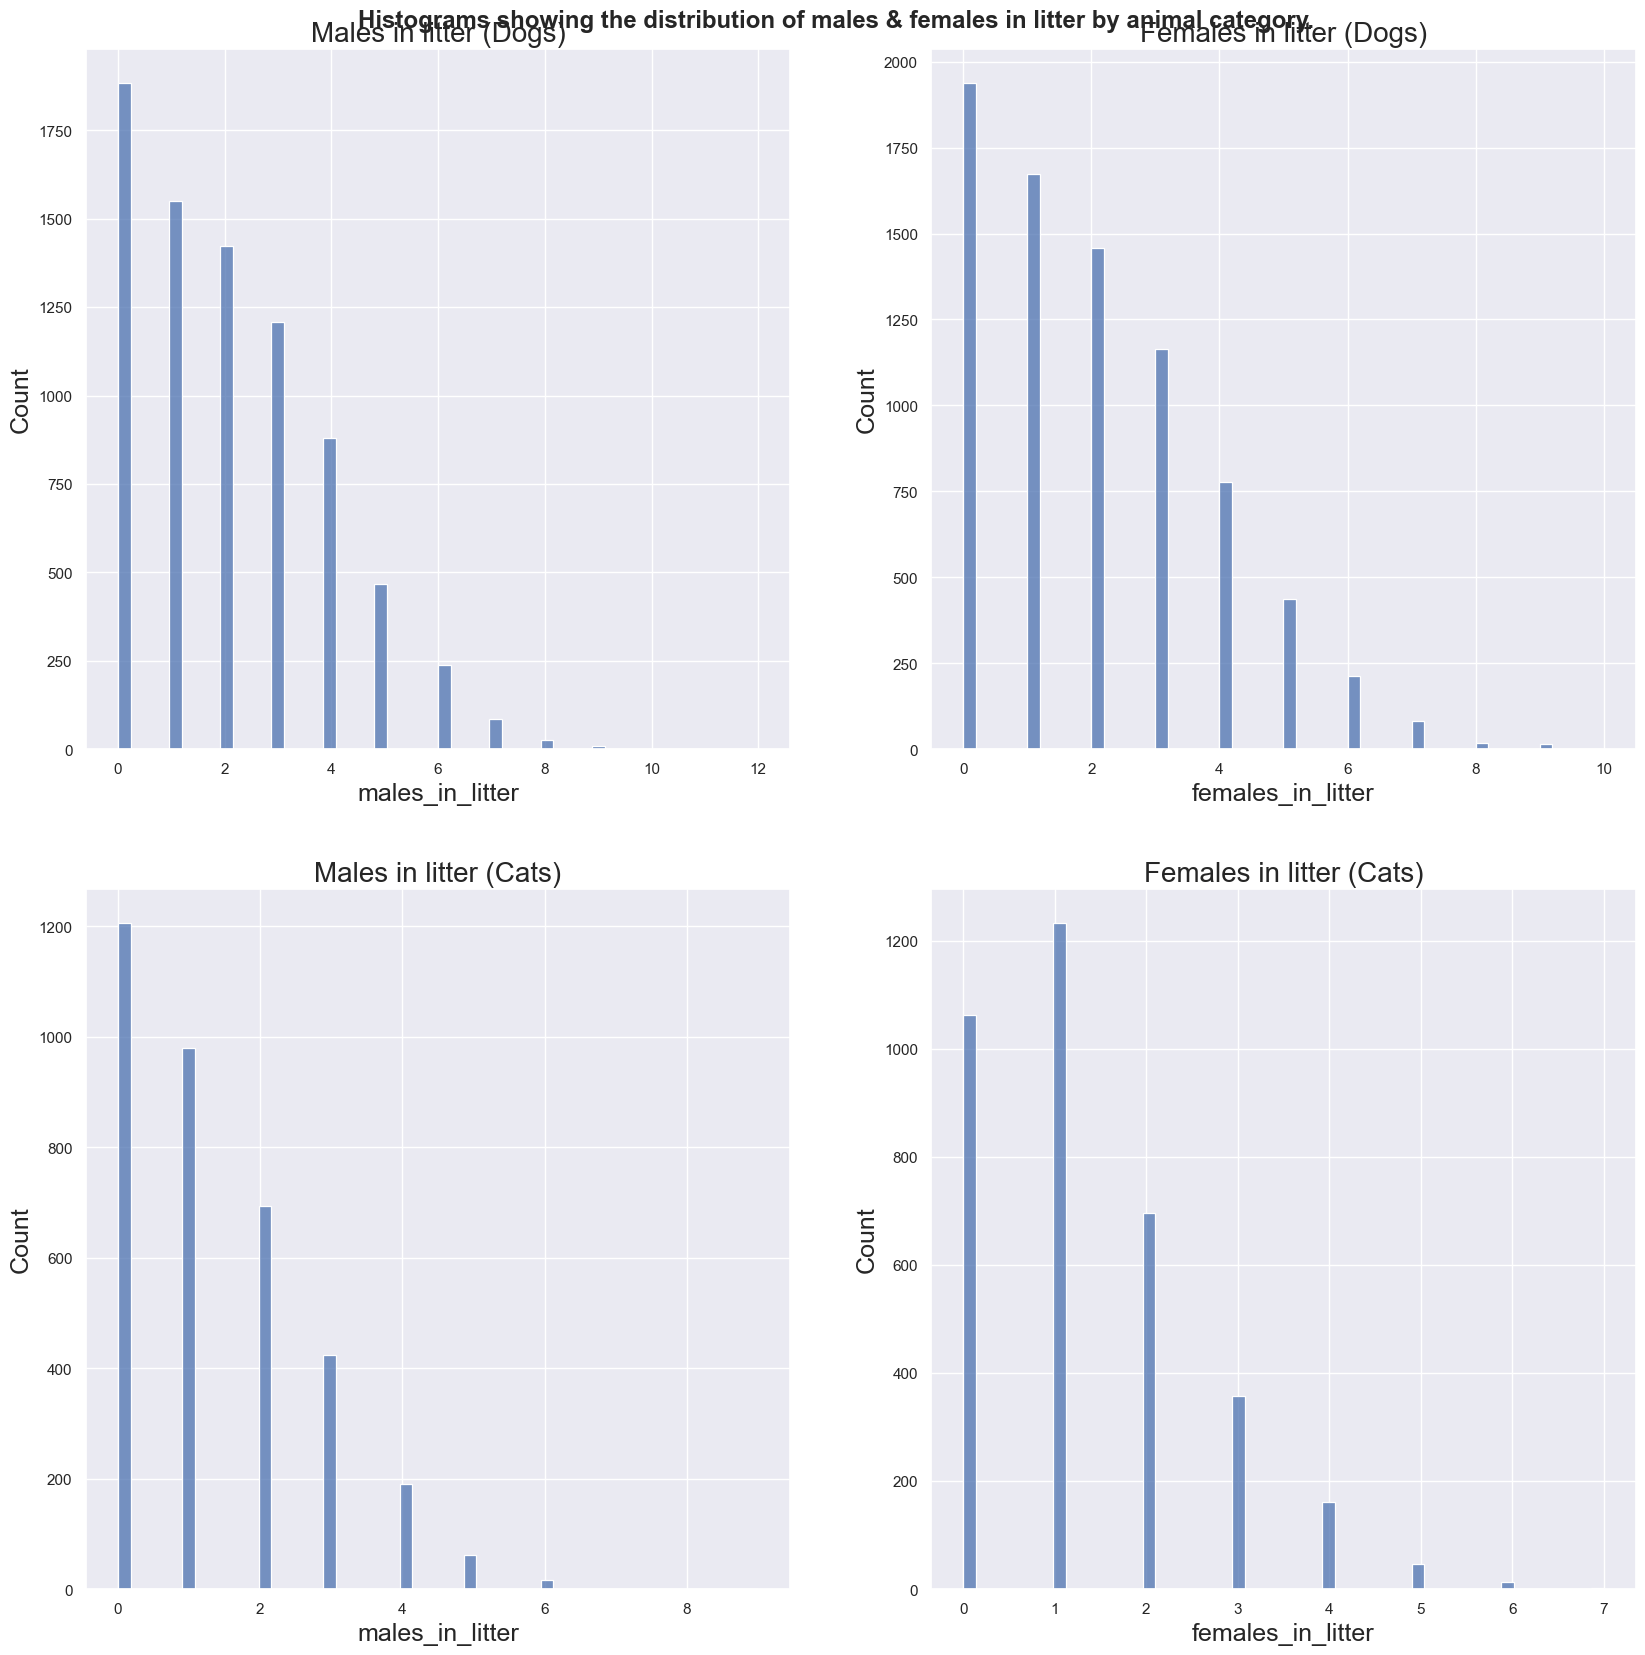

In [28]:
# setting label sizes
sns.set(rc = {'axes.labelsize' : 18 })

fig, ax = plt.subplots(2,2,figsize=(20,20))

# setting fig title
fig.suptitle("Histograms showing the distribution of males & females in litter by animal category." ,
             fontsize = 'x-large', 
             fontweight = 'bold',
             y=.9);

# generating histograms
plot_row = 0
plot_col = 0

sns.histplot(pets_df[pets_df['category'] == 'Dogs']['males_in_litter'],
                 bins = 50,
                 ax=ax[0, 0]).set_title('Males in litter (Dogs)', size = 20);

sns.histplot(pets_df[pets_df['category'] == 'Dogs']['females_in_litter'],
                 bins = 50,
                 ax=ax[0, 1]).set_title('Females in litter (Dogs)', size = 20);

sns.histplot(pets_df[pets_df['category'] == 'Cats']['males_in_litter'],
                 bins = 50,
                 ax=ax[1, 0]).set_title('Males in litter (Cats)', size = 20);

sns.histplot(pets_df[pets_df['category'] == 'Cats']['females_in_litter'],
                 bins = 50,
                 ax=ax[1, 1]).set_title('Females in litter (Cats)', size = 20);

**Checking the linearity of the relationships between the continuous variables and the target.** The four scatter plots below show the relationship between litter size (i.e. males_in_litter + females_in_litter), pets_age_in_days, n_images and n_adverts with the target variable. Each plot has a order 2 regression line fitted through it (n.b. I experimented with other orders, but found 2 the best fit for each). These plots suggest that all of the continuous variables have a nonlinear relationship with the target. Specifically:
 - smaller and larger litters are associated with a lower price, whereas mid-sized litters are associated with higher prices. This reflects the information from Pets4Homes about healthy litter sizes quoted above. 
 - younger and older pets are associated with higher prices, whereas those in the mid-range are associated with lower prices. This is likely becuase people are typically interested in buying their pet when it is an infant and as pets age, they become cheaper. However, this would only be up to a point, as some long-lived animals (such as horses, large parrots, tortoises etc) can be particularly expensive.
 - smaller and large numbers of images are associated with lower price, whereas listings with 25 to 30 images are associated with higher prices. I would speculate that this is because more images, in and of itself, is typically a good thing, but very high numbers of images may be associated with other factors which are associated with lower prices. For instance, larger litters may have more images. Animals which are sometimes bred in large numbers (e.g. invertebrates, fish, birds, rodents, rabbits etc.) would require more images and are amongst the cheaper categories.
 - fewer adverts are associated with a higher price. This makes sense, as sellers who list animals which are more time or effort intensive to breed are likely to list fewer animals, but charge greater amounts for them. Whilst the regression line does curve back up as the number of adverts climbs, this is likely due to the single seller with 140 adverts, who may charge more than other sellers who list multiple adverts. 
 
All in all, these four plots indicate that it may be beneficial to create polynomial features for the continuous variables. 

/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


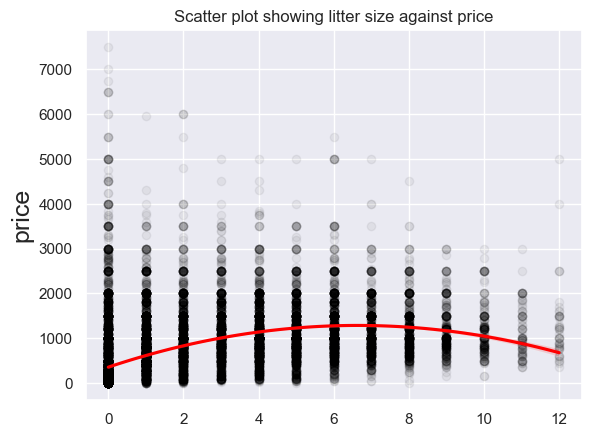

In [29]:
sns.regplot(pets_df['males_in_litter']+pets_df['females_in_litter'], 
            pets_df['price'],
            scatter_kws={"color": "black",'alpha':0.05}, 
            line_kws={"color": "red"},
            order=2).set_title('Scatter plot showing litter size against price');

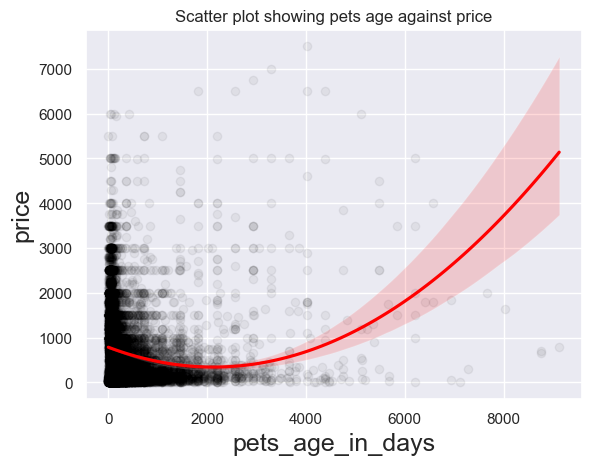

In [30]:
sns.regplot(pets_df['pets_age_in_days'], 
            pets_df['price'],
            scatter_kws={"color": "black",'alpha':0.05}, 
            line_kws={"color": "red"},
            order=2).set_title('Scatter plot showing pets age against price');

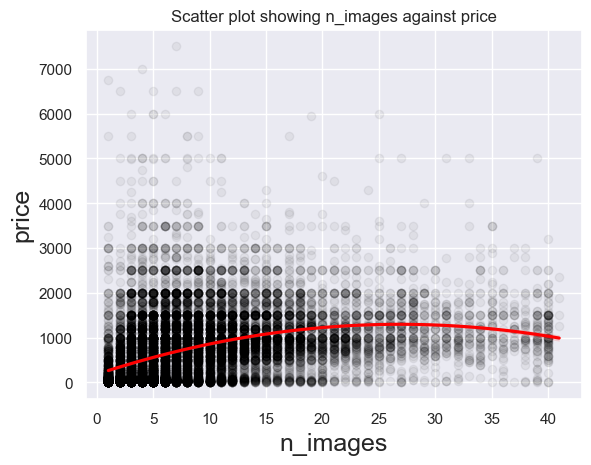

In [31]:
sns.regplot(pets_df['n_images'], 
            pets_df['price'],
            scatter_kws={"color": "black",'alpha':0.05}, 
            line_kws={"color": "red"},
            order=2).set_title('Scatter plot showing n_images against price');

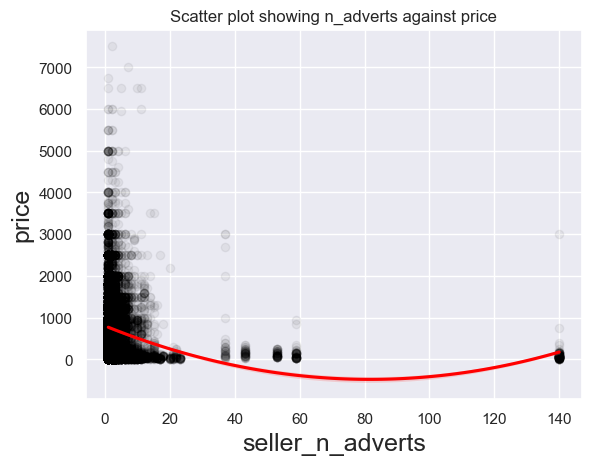

In [32]:
sns.regplot(pets_df['seller_n_adverts'], 
            pets_df['price'],
            scatter_kws={"color": "black",'alpha':0.05}, 
            line_kws={"color": "red"},
            order=2).set_title('Scatter plot showing n_adverts against price');

**Heat map showing correlations amongs continuous variables** The heatmap below shows that n_images and fe/males_in_litter are the best linear predictors of price amongst the continuous variables. seller_n_advets is slightly negatively correlated with price. This is likely because animals with longer infancies (dogs, cats horses), which nessecarily require more time and care, are amongst the more expensive categories. Whereas those which could feasibly be breed in larger numbers (leading to more adverts), such as rabbits, rodents and fish, are amongst the cheaper pets. 

Due to the non-linear relationships uncovered above, it is unsurprising that there are no strong correlations here.

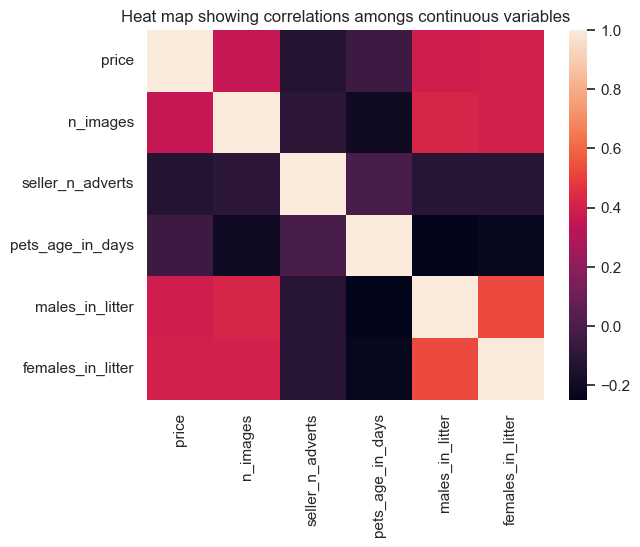

In [33]:
sns.heatmap(pets_df[continuous_vars].corr()).set_title("Heat map showing correlations amongs continuous variables");

## Binary variables

The first step with the binary variables will need to be seperating out the 'Not applicable' and 'Unlisted' values from the columns which would otherwise be purely binary. These can then be combined with the purely binary variables (i.e. those relating to verification) for analysis.

In [34]:
# removing jumping horse, dressage horse, as this information is duplicated in the horse category 1 & 2 columns
binary_vars_with_NAs = binary_vars_with_NAs[:-2]
binary_vars_with_NAs

['microchipped',
 'neutered',
 'vaccinated',
 'worm_treated',
 'registered',
 'original_breeder',
 'viewable_with_mother']

In [35]:
binary_vars

['phone_verified',
 'email_verified',
 'facebook_verified',
 'google_verified',
 'males_in_litter_NA',
 'females_in_litter_NA',
 'males_in_litter_UNLISTED',
 'females_in_litter_UNLISTED']

In [36]:
pets_binary = pd.get_dummies(pets_df[binary_vars_with_NAs]).join(pets_df[binary_vars]).join([pets_df['price']])

Where the column is applicable:
 - 66% of pets are microchipped
 - 6.5% of pets are neutered
 - 75% of pets are vaccinated
 - 91.6% of pets are worm treated
 - 96.6% of pets are being sold by the original breeder
 - 90.2% of pets are viewable with their mother
 - ~100% of sellers are phone verified (20 are not)
 - ~100% of sellers are email verified (41 are not)
 - 15% of sellers are Facebook verified
 - 15% of sellers are Google verified

In [37]:
pets_binary.mean()

microchipped_Not applicable                           0.40
microchipped_no                                       0.20
microchipped_yes                                      0.40
neutered_Not applicable                               0.38
neutered_no                                           0.58
neutered_yes                                          0.04
vaccinated_Not applicable                             0.40
vaccinated_no                                         0.15
vaccinated_yes                                        0.45
worm_treated_Not applicable                           0.40
worm_treated_Unlisted                                 0.00
worm_treated_no                                       0.05
worm_treated_yes                                      0.55
registered_0.0                                        0.39
registered_1.0                                        0.21
registered_Not applicable                             0.40
original_breeder_Not applicable                       0.

In [38]:
pets_binary.columns

Index(['microchipped_Not applicable', 'microchipped_no', 'microchipped_yes',
       'neutered_Not applicable', 'neutered_no', 'neutered_yes',
       'vaccinated_Not applicable', 'vaccinated_no', 'vaccinated_yes',
       'worm_treated_Not applicable', 'worm_treated_Unlisted',
       'worm_treated_no', 'worm_treated_yes', 'registered_0.0',
       'registered_1.0', 'registered_Not applicable',
       'original_breeder_Not applicable', 'original_breeder_Unlisted',
       'original_breeder_no', 'original_breeder_yes',
       'viewable_with_mother_Not applicable', 'viewable_with_mother_Unlisted',
       'viewable_with_mother_no', 'viewable_with_mother_yes', 'phone_verified',
       'email_verified', 'facebook_verified', 'google_verified',
       'males_in_litter_NA', 'females_in_litter_NA',
       'males_in_litter_UNLISTED', 'females_in_litter_UNLISTED', 'price'],
      dtype='object')

**Heat map showing correlations amongs binary variables and price** The heatmap below allows us to see which binary variables have the strongest correlations with the target variable, price. These correlations can be seen on the bottom row of the heatmap. This row shows that an animal being microchipped, vaccinated, worm treated, being sold by the original breeder, being viewable with it's mother and not being neutered are all positively correlated with price. 

Since most of these features are specific to dogs and cats and these animals are amongst the more expensive categories, I wanted to check that these positive correlations were not simply due to them being associated with cats and dogs. As such, I have created a 2nd heatmap below the first which displays the corrleations amongst the sample variables, but for cats and dogs only. Whilst the 2nd heatmap shows positive correlations between the variables mentioned above and the target variable, the size of the correlations have reduced considerably. This is particularly true for worm_treated_yes and neutered_no (the size of which becomes negligable).

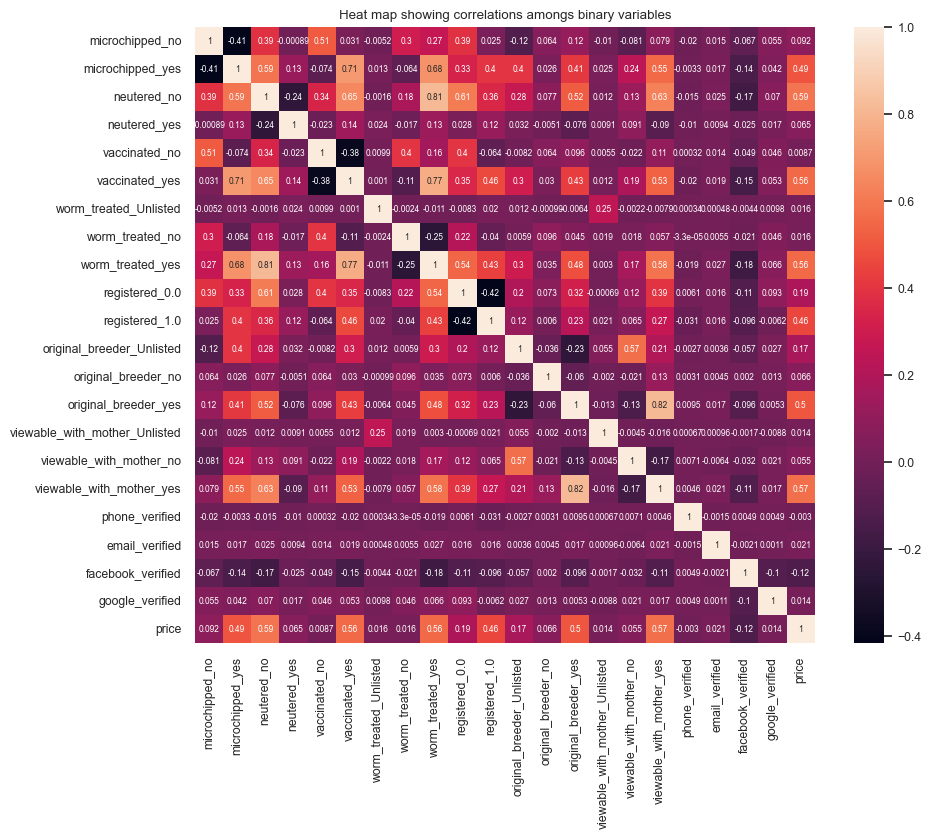

In [39]:
pets_binary_no_NAs = ['microchipped_no', 
                      'microchipped_yes', 
                      'neutered_no', 
                      'neutered_yes',
                      'vaccinated_no', 
                      'vaccinated_yes',
                      'worm_treated_Unlisted',
                      'worm_treated_no', 
                      'worm_treated_yes', 
                      'registered_0.0',
                      'registered_1.0',
                      'original_breeder_Unlisted',
                      'original_breeder_no', 
                      'original_breeder_yes',
                      'viewable_with_mother_Unlisted',
                      'viewable_with_mother_no',
                      'viewable_with_mother_yes',
                      'phone_verified',
                      'email_verified',
                      'facebook_verified',
                      'google_verified',
                      'price']

sns.set(font_scale = .8)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pets_binary[pets_binary_no_NAs].corr(),
            annot = True,
            annot_kws={'size': 6}
           ).set_title("Heat map showing correlations amongs binary variables");

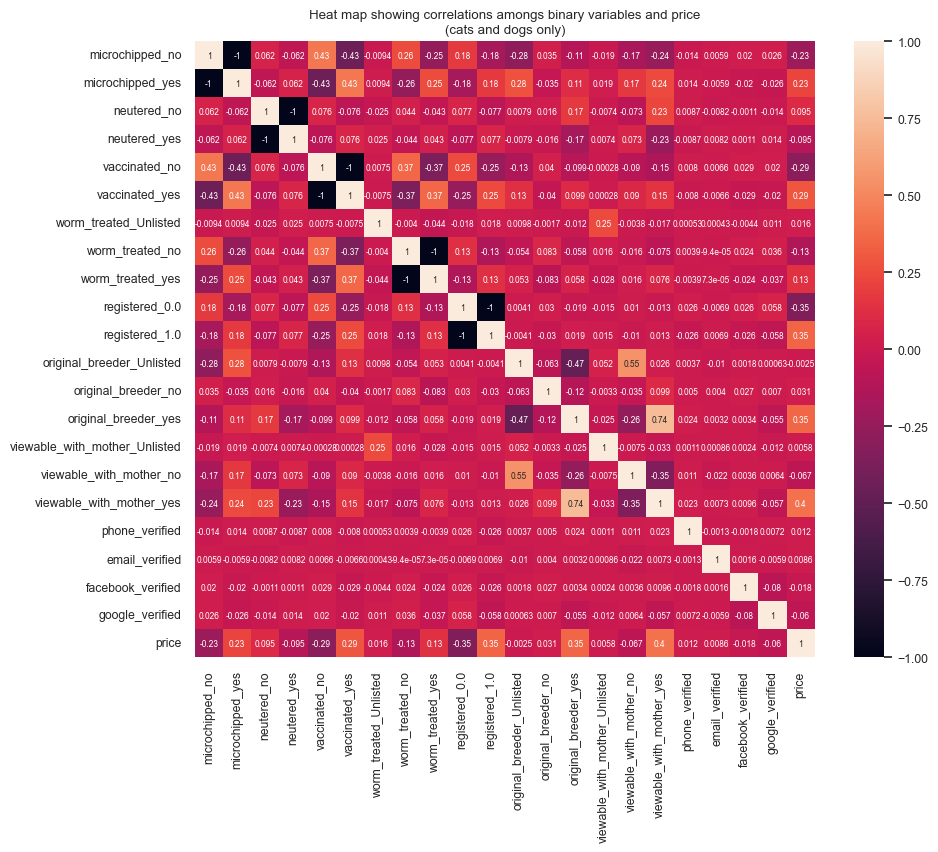

In [40]:
dogs_and_cats_only = pets_df[(pets_df['category'] == 'Dogs') | (pets_df['category'] == 'Cats')]
dogs_and_cats_only_binary = pd.get_dummies(dogs_and_cats_only[binary_vars_with_NAs]).join(dogs_and_cats_only[binary_vars]).join([dogs_and_cats_only['price']])
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dogs_and_cats_only_binary[pets_binary_no_NAs].corr(),
            annot = True,
            annot_kws={'size': 6}
           ).set_title("Heat map showing correlations amongs binary variables and price\n(cats and dogs only)");

/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lewis/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

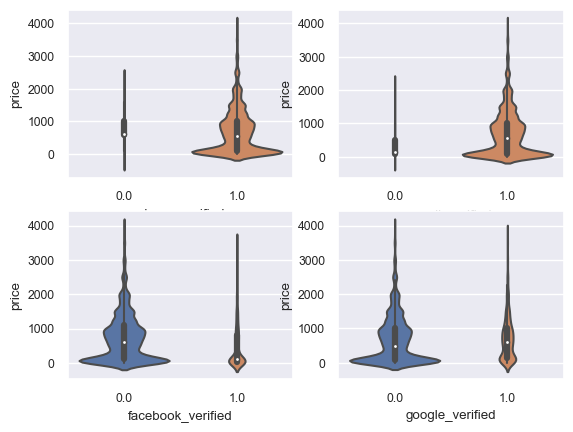

In [41]:
fig, ax = plt.subplots(2,2)

sns.violinplot(pets_binary['phone_verified'],pets_df[pets_df['price'] < 4000]['price'],
                scale = 'count',
                ax=ax[0,0]);
sns.violinplot(pets_binary['email_verified'],pets_df[pets_df['price'] < 4000]['price'],
                scale = 'count',
                ax=ax[0,1]);
sns.violinplot(pets_binary['facebook_verified'],pets_df[pets_df['price'] < 4000]['price'],
                scale = 'count',
                ax=ax[1,0]);
sns.violinplot(pets_binary['google_verified'],pets_df[pets_df['price'] < 4000]['price'],
                scale = 'count',
                ax=ax[1,1]);

## Categorical variables

There are 8 categorical variables (category, advert_location, advertiser_type, breed, pet_colour, pet_sex, category_1, category_2). For each of these, I have created a bar chart indicating the value counts for each level that particular variable. Each has a small section of markdown discussing the graph above it.

**category** - by far the most common category of pet is dogs, which make up almost half of the dataset. There are more than twice as many dog listings as the 2nd most common category, cats. Given how much the prices vary between the different catergories and how few instances there are of both the horses and invertebrates categories (amongst the most and least expensive categories), it may be difficult to make accurate predictions across all categories.

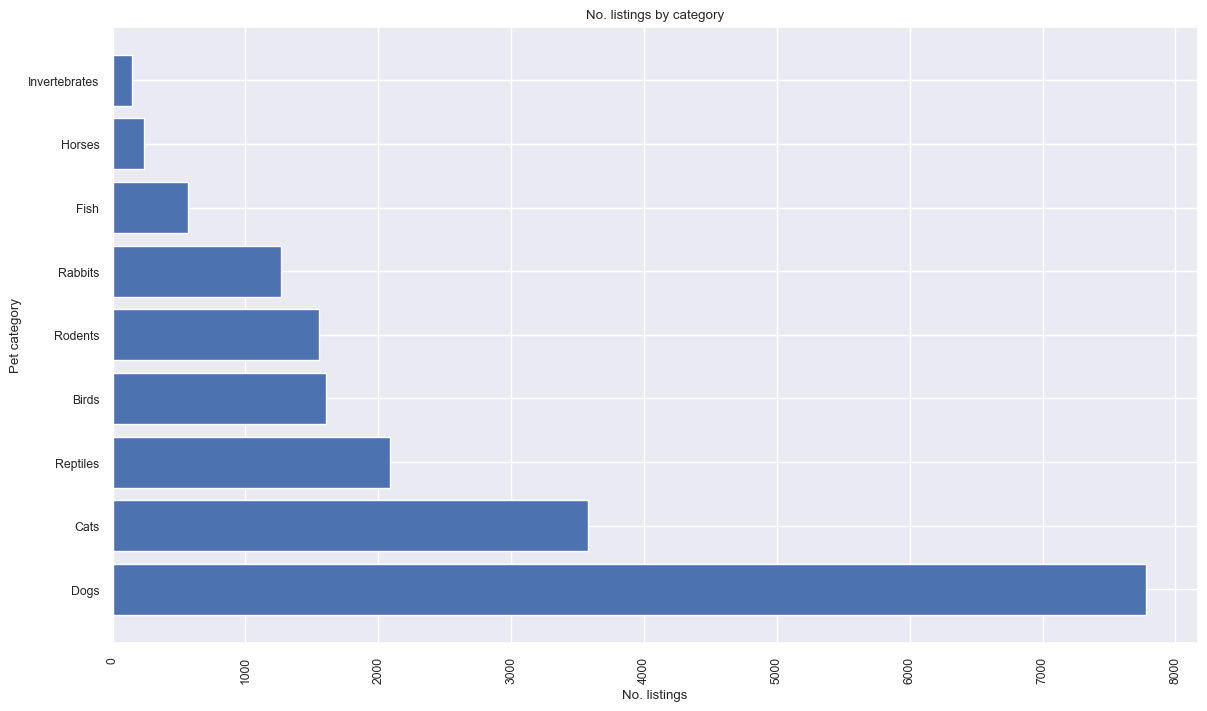

In [42]:
fig, ax = plt.subplots(figsize = [14,8])
plt.barh(pets_df['category'].value_counts().index, pets_df['category'].value_counts());
plt.xticks(rotation = 90);
plt.title('No. listings by category');
plt.ylabel('Pet category');
plt.xlabel('No. listings');

**advert_location** - There are 1163 unique locations. Only 408 of these have more than 10 listings, and only 23 have more than 100 listings. By far the most common location is London, which, with over 1000 adverts, has more than double the 2nd most common location, Birmingham. 

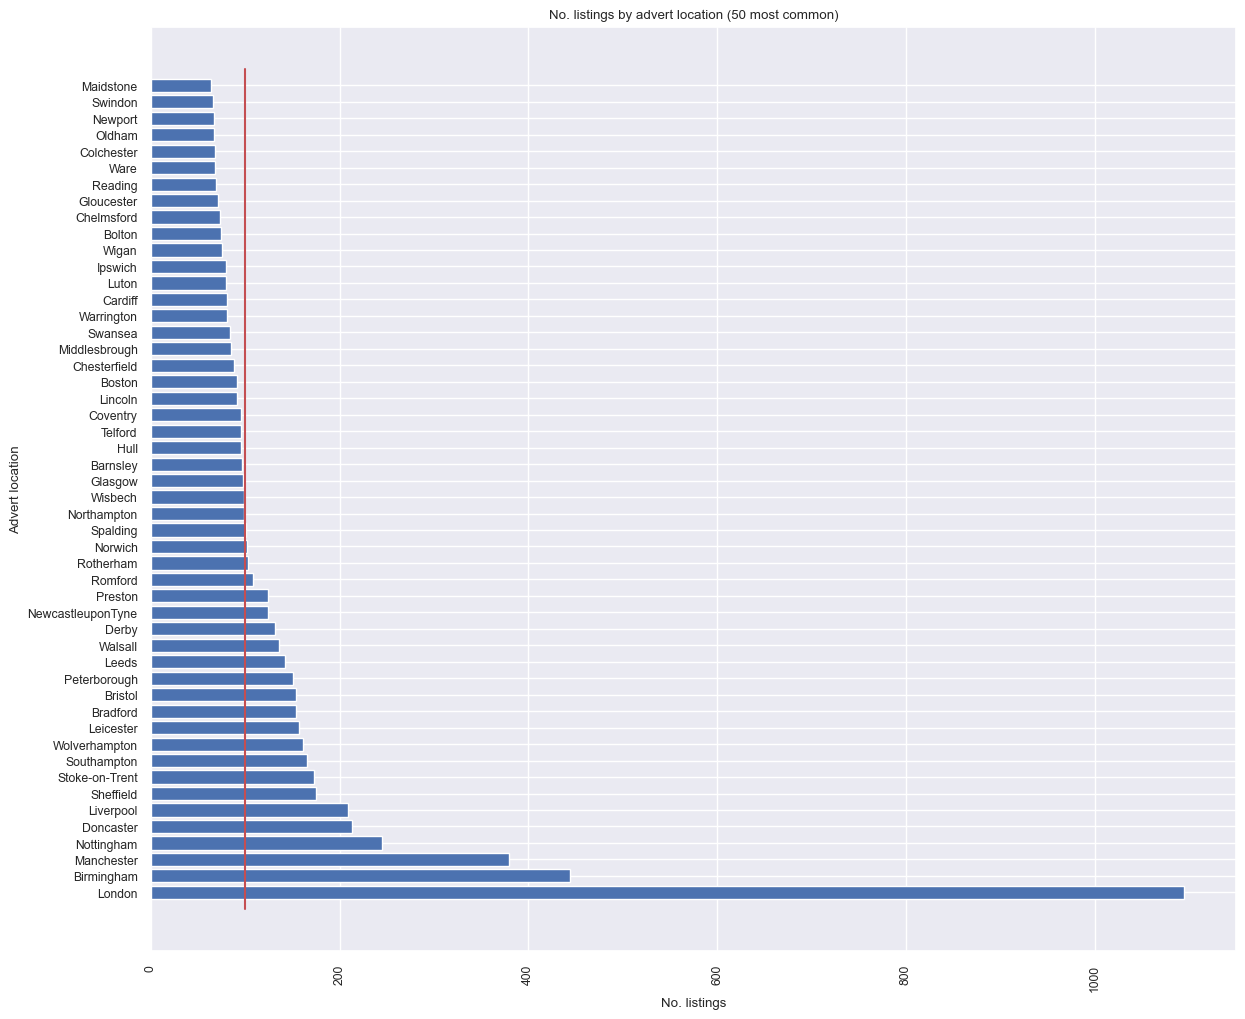

In [43]:
fig, ax = plt.subplots(figsize = [14,12])
plt.barh(pets_df['advert_location'].value_counts().index[:50], pets_df['advert_location'].value_counts()[:50]);
plt.xticks(rotation = 90);
plt.title('No. listings by advert location (50 most common)');
plt.ylabel('Advert location');
plt.xlabel('No. listings');
plt.plot([100,100],[-1,50],c='r');

**advertiser_type** - There are 5 unique types of advertiser (individual, breeder, liscened breeder, organisation and company). Adverts listed by organisations and companies are extremely rare.

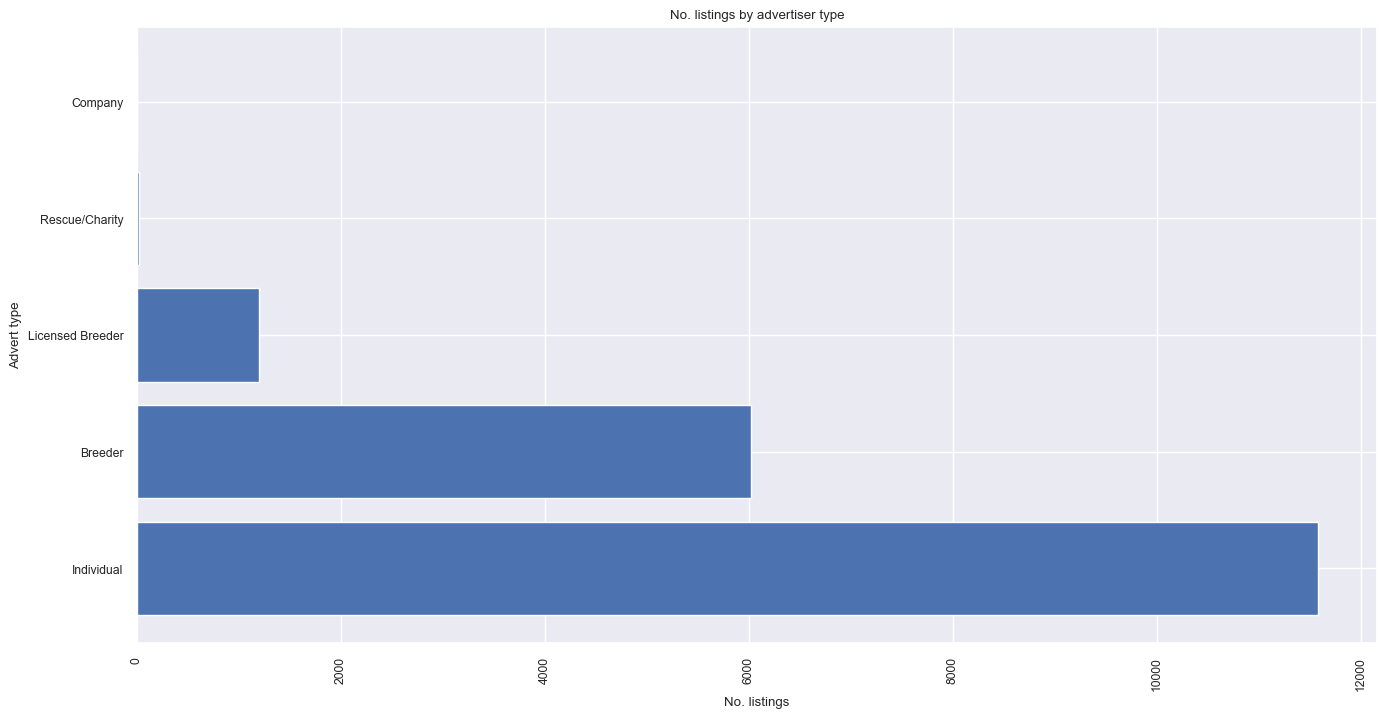

In [44]:
fig, ax = plt.subplots(figsize = [16,8])
plt.barh(pets_df['advertiser_type'].value_counts().index, pets_df['advertiser_type'].value_counts());
plt.xticks(rotation = 90);
plt.title('No. listings by advertiser type');
plt.ylabel('Advert type');
plt.xlabel('No. listings');

**breed** - There are 382 unique breeds in the dataset. Of these, 178 have more than 10 listings and 48 have more than 100. Mixed breed is the most common value. However, as this can apply to any animal category, I have added the category type to the breed value of any mixed breed animals (e.g. a mixed breed animal in the category dogs becomes 'Mixed Breed Dogs'). I have done this as I suspect that an animal being mixed breed may have a different impact on price depending upon the type of animal it is (e.g. a mixed breed dog or cat may be less valuable than a pedigree one, but I do not know if this is likely to be the case for, say, reptiles or birds). After cleaning these values, the most common breed type is Guinea Pig.

In [45]:
pets_df.loc[pets_df['breed'] == 'Mixed Breed','breed'] = pets_df.loc[pets_df['breed'] == 'Mixed Breed','breed'] + " " + pets_df.loc[pets_df['breed'] == 'Mixed Breed','category']

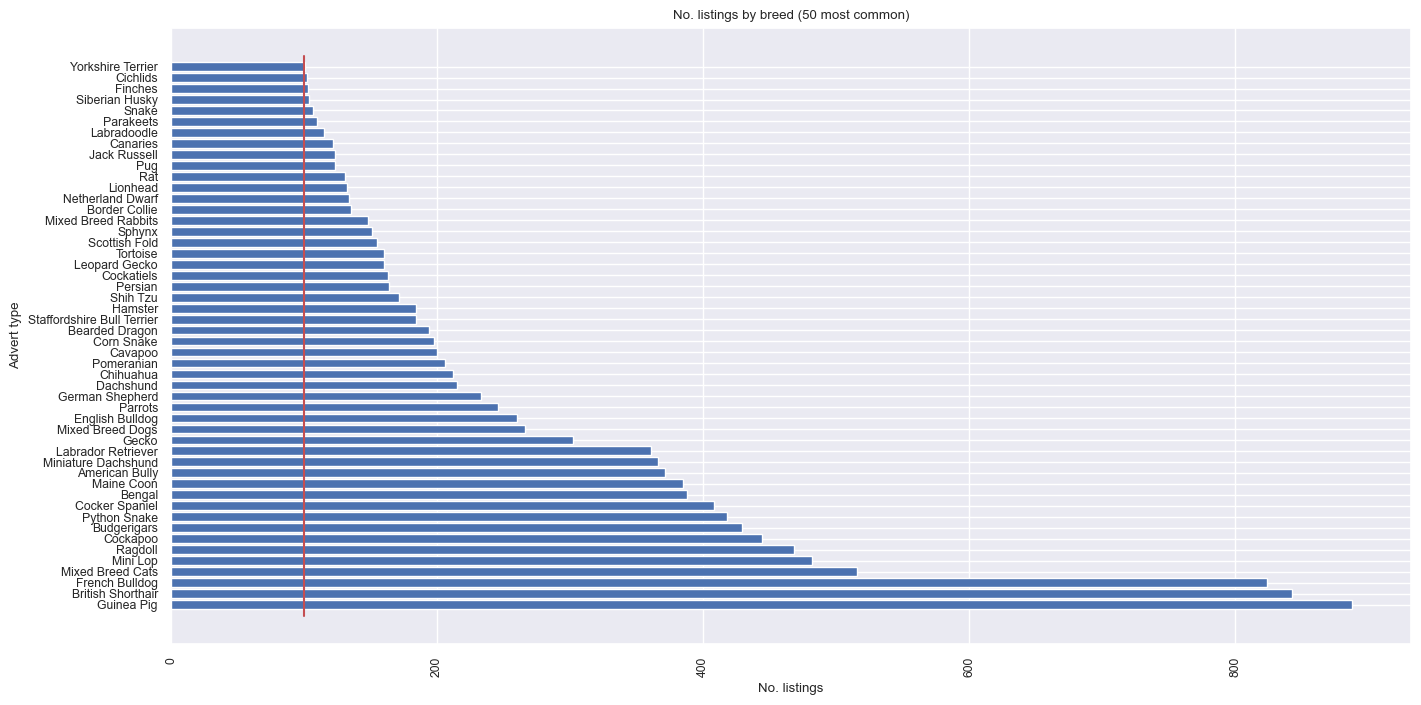

In [46]:
fig, ax = plt.subplots(figsize = [16,8])
plt.barh(pets_df['breed'].value_counts().index[:50], pets_df['breed'].value_counts()[:50]);
plt.xticks(rotation = 90);
plt.title('No. listings by breed (50 most common)');
plt.ylabel('Advert type');
plt.xlabel('No. listings');
plt.plot([100,100],[-1,50],c='r');

**pet_colour** - This variable needs some additional processing as some animals have multiple values (e.g. 'Brown, black, white'). I've seperated these using a count vectoriser (n.b. this means single adverts may not count towards multiple colour columns).

The bar chart shows that all colours except violet and pink appear in a listing more than 100 times. The most common colour entry is mixed colour, followed by black. For the majority of adverts listed, colour is either not applicable or is unlisted.

In [47]:
# count vectorizing pet_colour
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(token_pattern='\w+', stop_words=None)
cvec.fit(pets_df['pet_colour'])
pet_colour_df = pd.DataFrame(cvec.transform(pets_df['pet_colour']).toarray(),
                  columns=['pet_colour_'+i for i in cvec.get_feature_names()])

/Users/lewis/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
# cleaning pet_colour_df columns
pet_colour_df['pet_colour_not_applicable'] = pet_colour_df['pet_colour_applicable'] + pet_colour_df['pet_colour_not']
pet_colour_df['pet_colour_mixed_colour'] = pet_colour_df['pet_colour_mixed'] + pet_colour_df['pet_colour_color']
pet_colour_df.drop(columns=['pet_colour_applicable','pet_colour_not','pet_colour_mixed','pet_colour_color'],inplace = True)

# adding count vectorized/dummified columns back to pets_df
pets_df = pets_df.reset_index(drop=True).join(pet_colour_df.reset_index(drop=True))

# dropping original pet_colour column
pets_df.drop(columns = 'pet_colour', inplace = True)

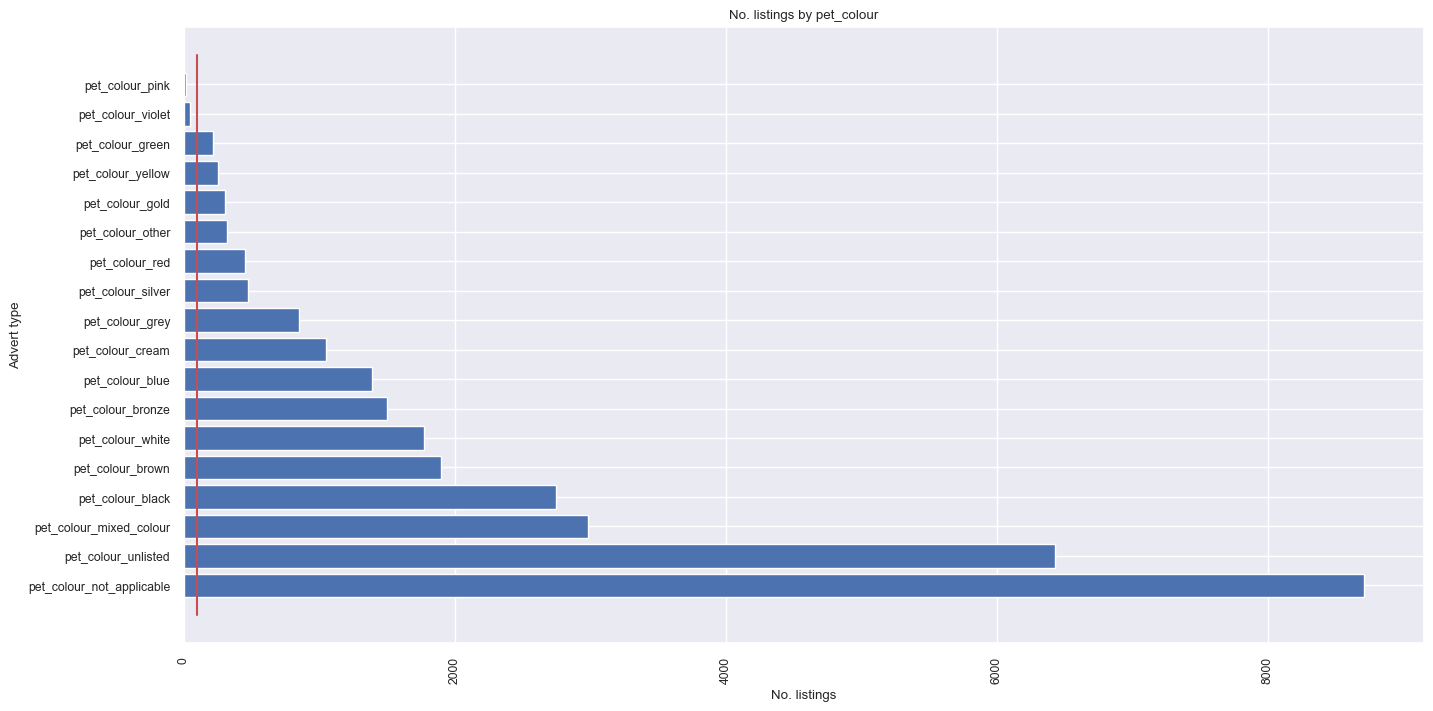

In [49]:
fig, ax = plt.subplots(figsize = [16,8])
plt.barh(pet_colour_df.sum().sort_values(ascending = False).index, 
        pet_colour_df.sum().sort_values(ascending = False));
plt.xticks(rotation = 90);
plt.title('No. listings by pet_colour');
plt.ylabel('Advert type');
plt.xlabel('No. listings');
plt.plot([100,100],[-1,len(pet_colour_df.sum().index)],c='r');

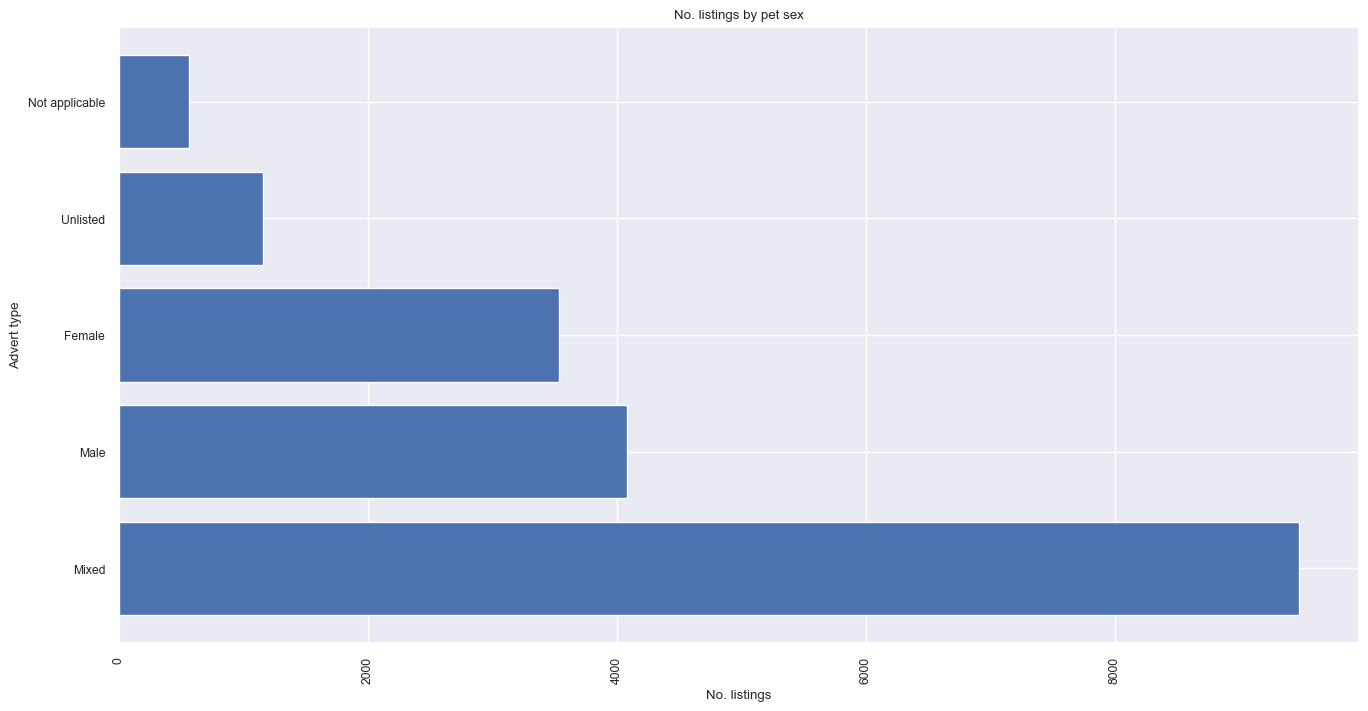

In [50]:
fig, ax = plt.subplots(figsize = [16,8])
plt.barh(pets_df['pet_sex'].value_counts().index, pets_df['pet_sex'].value_counts());
plt.xticks(rotation = 90);
plt.title('No. listings by pet sex');
plt.ylabel('Advert type');
plt.xlabel('No. listings');

**category_1/category_2** These two variables only apply to horses and specify the primary and secondary categories which the horse belongs to. By far the most common category_1 value is allrounder. The most common category_2 value is other. Given this, and the fact that horses make up a very small percentage of the overall dataset, I do not expect these features to be particularly useful for predicting price. 

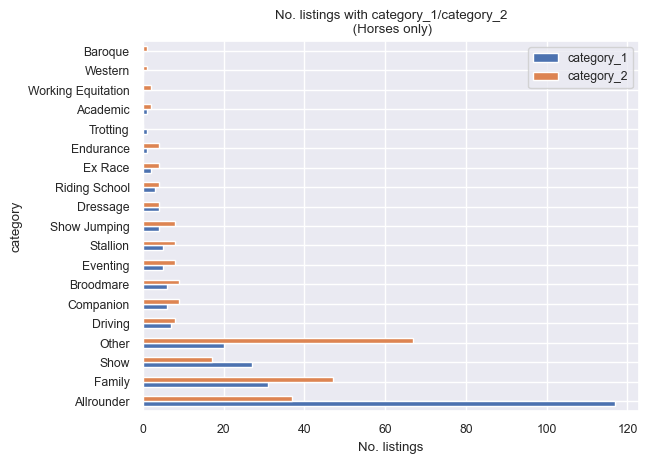

In [51]:
cat_1_and_2 = pd.concat([pets_df['category_1'].value_counts(), pets_df['category_2'].value_counts()], axis=1);
cat_1_and_2.drop('Not applicable', inplace = True);
cat_1_and_2.plot(kind='barh');
plt.title('No. listings with category_1/category_2\n (Horses only)');
plt.xlabel('No. listings');
plt.ylabel('category');

## Text variables

Both the title and description columns contain raw text. These will need to be processed before any analysis can be done on them. Given the large

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(token_pattern='\w+', stop_words='english')
cvec.fit(pets_df['title'])
df = pd.DataFrame(cvec.transform(pets_df['title']).toarray(),
                  columns=['title_'+i for i in cvec.get_feature_names_out()])

print(df.sum().sort_values(ascending = False)[df.sum().sort_values(ascending = False)>200])

title_puppies      2727
title_sale         2023
title_beautiful    1770
title_kittens      1435
title_female       1373
                   ... 
title_xl            209
title_sold          209
title_lilac         207
title_royal         206
title_looking       204
Length: 78, dtype: int64


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(norm='l2', stop_words='english', ngram_range=(1,2))
tvec.fit(pets_df['title'])

df = pd.DataFrame(tvec.transform(pets_df['title']).toarray(),
                  columns=['title_'+i for i in tvec.get_feature_names_out()])

print(df.sum()[df.sum()>100])

title_available                         108.92
title_baby                              233.53
title_beautiful                         336.28
title_blue                              144.08
title_boy                               136.89
title_british                           138.80
title_british shorthair                 104.75
title_budgies                           138.90
title_bulldog                           191.23
title_cocker                            115.78
title_dachshund                         106.76
title_female                            272.96
title_french                            178.23
title_french bulldog                    139.50
title_girl                              130.72
title_gorgeous                          124.48
title_guinea                            173.14
title_guinea pigs                       142.64
title_kc                                193.27
title_kitten                            119.19
title_kittens                           337.55
title_left   

In [54]:
title_Tfid_corrs = df.corrwith(pets_df['price']).sort_values(ascending = False)

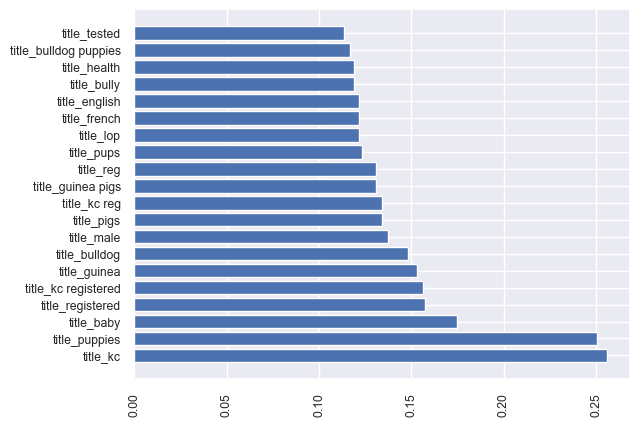

In [55]:
plt.barh(title_Tfid_corrs.dropna().abs().sort_values(ascending = False)[:20].index, title_Tfid_corrs.dropna().abs().sort_values(ascending = False)[:20]);
plt.xticks(rotation = 90);

In [56]:
tvec = TfidfVectorizer(norm='l2', stop_words='english', ngram_range=(1,2))
tvec.fit(pets_df['description'])

df = pd.DataFrame(tvec.transform(pets_df['description']).toarray(),
                  columns=['description_'+i for i in tvec.get_feature_names()])

print(df.sum()[df.sum()>100])

/Users/lewis/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


description_available                  226.50
description_babies                     102.29
description_baby                       105.25
description_beautiful                  233.71
description_black                      180.68
                                 ...         
description_vaccinated                 113.44
description_vet                        126.40
description_weeks                      176.26
description_white                      167.34
description_wormed                     154.75
Length: 80, dtype: float64


In [57]:
print(df.sum()[df.sum()>100].sort_values(ascending = False))

description_puppies                   341.83
description_home                      283.41
description_kittens                   234.27
description_beautiful                 233.71
description_ready                     231.87
                                ...         
description_clear                     102.75
description_babies                    102.29
description_like                      101.32
description_mum dad                   100.56
description_used                      100.02
Length: 80, dtype: float64


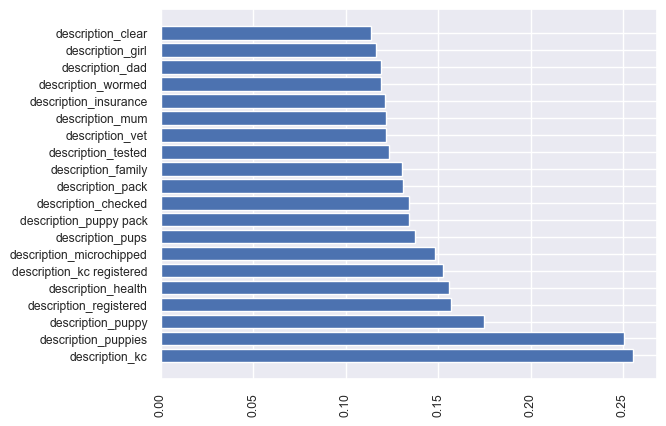

In [58]:
description_Tfid_corrs = df.corrwith(pets_df['price']).sort_values(ascending = False)
plt.barh(description_Tfid_corrs.dropna().abs().sort_values(ascending = False)[:20].index, title_Tfid_corrs.dropna().abs().sort_values(ascending = False)[:20]);
plt.xticks(rotation = 90);

Next steps...

In [61]:
pets_df.to_csv('/Users/lewis/Desktop/GA/DSI25-lessons/projects/project-capstone/data/cleaned_data_final.csv')